In [1]:
import faulthandler, sys, signal
faulthandler.enable(all_threads=True, file=sys.stderr)
faulthandler.register(signal.SIGUSR1, all_threads=True, file=sys.stderr)


In [2]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
import os, sys
import warnings
warnings.filterwarnings("ignore")
# os.environ['PROXY_URL'] = ''
from module_test.raw_code.DataManagers.DataManagers import (_SaveManager, 
                                                            OptionDataManager, 
                                                            ChainDataManager, 
                                                            DB_CACHE)
from EventDriven.riskmanager import RiskManager
from EventDriven.riskmanager.utils import (
 LOOKBACKS, 
 close_cache, 
 chain_cache, 
 oi_cache, 
 spot_cache,
 clear_cache,
 get_cache,
 populate_cache_with_chain,
 logger
)
from EventDriven.types import ResultsEnum
from trade.helpers.helper import (find_split_dates_within_range, 
                                  CustomCache)
from pathlib import Path
from trade.helpers.helper import (find_split_dates_within_range, 
                                  generate_option_tick_new)

from dbase.DataAPI.ThetaData import (list_contracts, resample, 
                                     retrieve_chain_bulk)
from trade.assets.Calculate import Calculate
from trade.helpers.threads import runThreads
from trade.helpers.helper import (parse_option_tick, 
                                  binomial_implied_vol, 
                                  retrieve_timeseries, 
                                  parse_option_tick, 
                                  change_to_last_busday)

from trade.assets.rates import get_risk_free_rate_helper
from dateutil.relativedelta import relativedelta
from dbase.DataAPI.ThetaData import retrieve_eod_ohlc
from pandas.tseries.offsets import BDay
from trade.assets.Stock import Stock
import pandas as pd
from datetime import datetime, timedelta
from trade.helpers.decorators import cProfiler, cprofiler_func
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)
import math
import matplotlib.pyplot as plt
import numpy as np


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-06-01 18:17:04 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://34.235.162.150:5500/thetadata


Scheduled Data Requests will be saved to: /Users/chiemelienwanisobi/cloned_repos/QuantTools/module_test/raw_code/DataManagers/scheduler/requests.jsonl


In [3]:
from trade.assets.rates import get_risk_free_rate_helper
(get_risk_free_rate_helper('1d'))

[get_engine] Creating engine for DB: securities_master, PID: 33818


,daily,annualized,name,description
Datetime,,,,
2010-01-01,0.000000,0.00000,0,0
2010-01-04,0.000002,0.00055,^IRX,13 week treasury bill
2010-01-05,0.000002,0.00060,^IRX,13 week treasury bill
2010-01-06,0.000001,0.00045,^IRX,13 week treasury bill
2010-01-07,0.000001,0.00045,^IRX,13 week treasury bill
...,...,...,...,...
2025-05-26,0.000114,0.04230,^IRX,13 WEEK TREASURY BILL
2025-05-27,0.000114,0.04230,^IRX,13 WEEK TREASURY BILL
2025-05-28,0.000113,0.04203,^IRX,13 WEEK TREASURY BILL


In [4]:
from EventDriven.portfolio import OptionSignalPortfolio
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
from functools import partial


# ***Extending Risk Manager for greek handling***

### ***INITIAL BACKTEST RUN***

In [18]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
_key = 11
with open(f'../input/profitable_weights_{_key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../input/profitable_trades_{_key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
tick = ['AAPL', 'NFLX', 'NVDA']
# ttrades__ = ttrades__[(ttrades__.Ticker.isin(tick))]
trades_ = ttrades__.iloc[5:10, :]
trades_ = ttrades__.iloc[9, :].to_frame().T
# trades_.loc[17, 'Size'] = -126
# ttrades__
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
9,112,588,617,156.867127,156.990005,13.762352,0.000783,2024-05-07,2024-06-18,42,AMD


### ISSUES:

11: [
    4: COST is giving very weird values. Issue is the entry day picked a Credit Spread with debit cost. Need to find a logic to avoid this entirely
]

In [20]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)


max_cash = {}
cash = 20_000
for s, w in weights.items():
    print(f'{s} {w} {w * cash}')
    if w * cash > 500:
        max_cash[s] = 4
    elif w * cash > 300:
        max_cash[s] = 3
    elif w * cash > 200:
        max_cash[s] = 2
    elif w * cash > 100:
        max_cash[s] = 1
    else:
        max_cash[s] = 0.5
max_cash
pd.Series(weights).sort_values(ascending=False), max_cash

AMD 0.1264165402671991 2528.330805343982


(AMD    0.126417
 dtype: float64,
 {'AMD': 4})

In [21]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo

pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)
evb_backtest.portfolio.initial_capital
w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.sizing_lev = 4.5
evb_backtest.portfolio.max_contract_price_factor = 2
evb_backtest.portfolio.min_moneyness_threshold = 3
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .70,
   'dte': 365,
   'moneyness_width': 0},
   {'direction': 'short',
  'rel_strike': .60,
  'dte': 365,
  'moneyness_width': 0}
],
 'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = max_cash
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.portfolio.min_moneyness_threshold = 5
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.roll_map = 90
evb_backtest.portfolio.moneyness_width_factor = .025
evb_backtest.portfolio.dte_reduction_factor = 30
evb_backtest.portfolio.min_acceptable_dte_threshold = 95
evb_backtest.portfolio.risk_manager.limits['dte'] = True
evb_backtest.portfolio.risk_manager.limits['delta'] = True
evb_backtest.portfolio.risk_manager.limits['moneyness'] = True
evb_backtest.portfolio.risk_manager.max_moneyness = 1.3
for key  in max_cash:
    if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
        print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])

evb_backtest.portfolio.risk_manager.print_settings()

signals = evb_backtest.bars.signal_df
signals_df = deepcopy(signals).set_index('Date')
((signals_df!=-1)&(signals_df!=-0)).sum().sum()
rm = evb_backtest.portfolio.risk_manager
pm = evb_backtest.portfolio


Risk Manager Settings:
Start Date: 2017-01-01
End Date: 2025-06-01
Current Limits State (Position Adjusted when these thresholds are reached):
    Delta: True
    Gamma: False
    Vega: False
    Theta: False
    Roll On DTE: True
        Min DTE Threshold: 95
    Roll On Moneyness: True
        Max Moneyness: 1.3
Quanitity Sizing Type: delta
            


In [22]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest
evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')
stats.print_stats()

Processing event: MARKET
Processing event: SIGNAL
2025-06-01 18:25:11 trade.asset.Stock ERROR: Error getting dividends history for AMD from yfinance
2025-06-01 18:25:11 trade.asset.Stock ERROR: Probably due to no dividends history
http://127.0.0.1:25510/v2/bulk_at_time/option/quote?root=AMD&exp=0&start_date=20240507&end_date=20240507&ivl=57600000&use_csv=true&right=C
http://127.0.0.1:25510/v2/bulk_at_time/option/quote?root=AMD&exp=0&start_date=20240507&end_date=20240507&ivl=57600000&use_csv=true&right=C
Retrieved chain for AMD on 2024-05-07

Order Received: {'result': 'SUCCESSFUL', 'data': {'trade_id': '&L:AMD20250321C175&S:AMD20250321C180', 'legs': {'short': ['AMD20250321C180'], 'long': ['AMD20250321C175']}, 'close': 2.099999999999998}}

Calculate Greeks Dates Start: 2017-01-01, End: 2025-06-01, Position ID: &L:AMD20250321C175&S:AMD20250321C180, Date: 2024-05-07
2025-06-01 18:25:38 QuantTools.EventDriven.riskmanager.utils CRITICAL: Position Data for &L:AMD20250321C175&S:AMD20250321C18

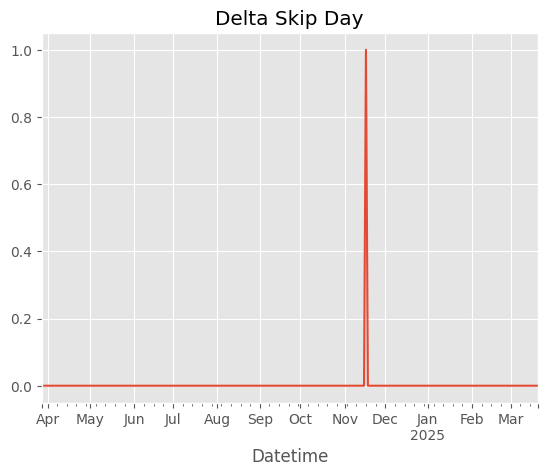

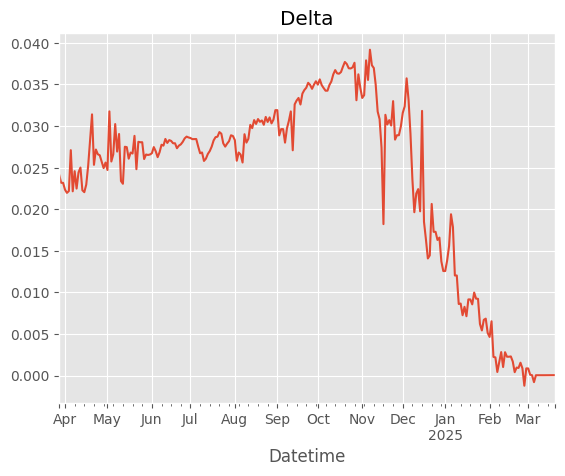

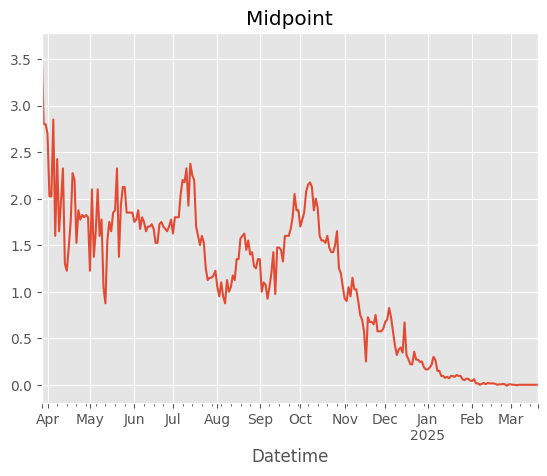

In [24]:
rm.greek_limits
(rm.position_data['&L:AMD20250321C175&S:AMD20250321C180'].Delta_skip_day[rm.start_date: rm.end_date] * 1).plot()
plt.title('Delta Skip Day') 
plt.show()

(rm.position_data['&L:AMD20250321C175&S:AMD20250321C180'].Delta[rm.start_date: rm.end_date] * 1).plot()
plt.title('Delta')
plt.show()

(rm.position_data['&L:AMD20250321C175&S:AMD20250321C180'].Midpoint[rm.start_date: rm.end_date] * 1).plot()
plt.title('Midpoint')
plt.show()

<Axes: >

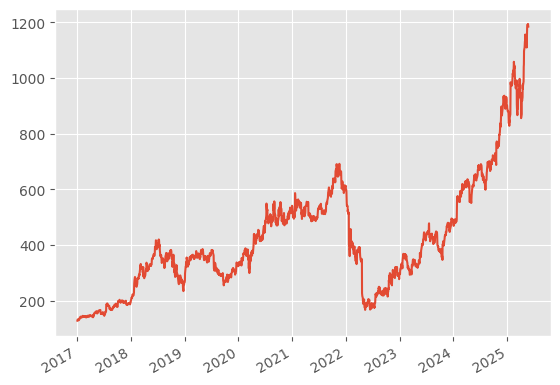

In [15]:
rm.spot_timeseries['NFLX'][rm.start_date:rm.end_date].plot()

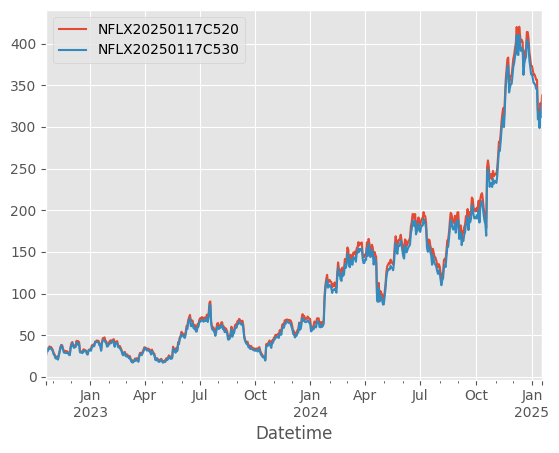

In [23]:
trade_id = '&L:NFLX20250117C520&S:NFLX20250117C530'
tick = ['NFLX20250117C520', 'NFLX20250117C530']
rm.processed_option_data[tick[0]].Midpoint[rm.start_date:rm.end_date].plot(label=tick[0])
rm.processed_option_data[tick[1]].Midpoint[rm.start_date:rm.end_date].plot(label=tick[1])
plt.legend()

In [93]:
l = rm.processed_option_data[tick[0]].copy()
s = rm.processed_option_data[tick[1]].copy()
filled_l = l.replace(0, np.nan).ffill()
filled_s = s.replace(0, np.nan).ffill()
filled_l.Midpoint.plot(label =f'Filled {tick[0]}')
filled_s.Midpoint.plot(label =f'Filled {tick[1]}')
plt.legend()


In [102]:
def _clean_data(df):
    """
    Cleans the data by removing rows with NaN values in specified columns.
    
    :param data: DataFrame to clean
    :param columns: List of columns to check for NaN values
    :return: Cleaned DataFrame
    """
    
    def fill_values(df):
        """
        Fills NaN values with the last valid observation.
        """
        return df.replace(0, np.nan).ffill()
    df = df.copy()
    return fill_values(df)
    
def add_skip_columns(df, skip_columns, window=20, skip_threshold=3):
    """
    Adds skip columns to the DataFrame.
    """
    for col in skip_columns:
        ## EMA Smoothing + Zscore Fiter
        smooth = df[col].ewm(span=3).mean()
        _zscore = (smooth - smooth.rolling(window).mean()) / smooth.rolling(window).std()
        df[f'{col}_skip_day']= (_zscore.abs() > skip_threshold) 
    return df

l = _clean_data(l)
s = _clean_data(s)
spread = l - s
spread = add_skip_columns(spread, ['Midpoint', 'Delta'])

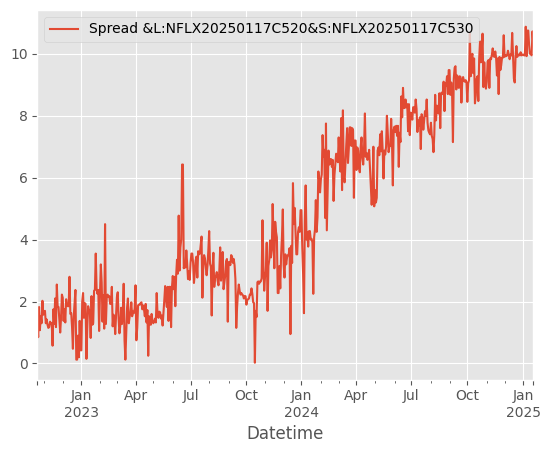

In [30]:
spread = (filled_l - filled_s)
spread.Midpoint[rm.start_date:rm.end_date].plot(label=f'Spread {trade_id}')
plt.legend()

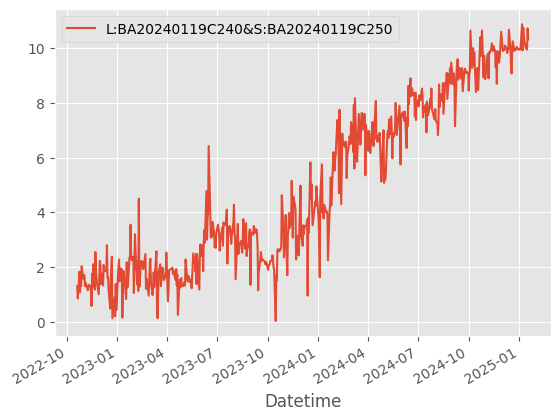

In [28]:
rm.position_data[ trade_id].dropna().Midpoint[rm.start_date:rm.end_date].plot(label='L:BA20240119C240&S:BA20240119C250')
plt.legend()
# pm.all_positions

In [129]:
from IPython.display import clear_output
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
_key = 11

ttrades__ = pd.read_csv(f'../input/profitable_trades_{_key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))

for index in ttrades__.index:
    trades_ = ttrades__.iloc[index, :].to_frame().T


    symbol_list = trades_.Ticker.unique()
    with open(f'../input/profitable_weights_{_key}.json', 'r') as f:
        weights = json.load(f)
    print(f"\n\nRunning backtest for trades {index} with symbols {symbol_list[0]}\n")
    untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
    for s in untraded_symbols:
        weights.pop(s)

    print(weights)


    max_cash = {}
    cash = 20_000
    for s, w in weights.items():
        if w * cash > 200:
            max_cash[s] = 2
        elif w * cash > 100:
            max_cash[s] = 1
        else:
            max_cash[s] = 0.5
    max_cash
    print(max_cash)
    print("\nSetting up backtest\n")
    #Backtest class 
    ## Find a way to not always reinitialize the backtest class, when want to redo

    pd.options.display.max_rows = 50
    pd.options.display.max_columns = 50

    evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)
    evb_backtest.portfolio.initial_capital
    w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
    evb_backtest.portfolio.weight_map = w_map
    evb_backtest.portfolio.weight_map
    evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
    evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
    evb_backtest.portfolio.risk_manager.sizing_lev = 4.5
    evb_backtest.portfolio.max_contract_price_factor = 2
    evb_backtest.portfolio.min_moneyness_threshold = 3
    evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
    evb_backtest.portfolio.order_settings = {'type': 'naked',
    'specifics': [{'direction': 'long',
    'rel_strike': .70,
    'dte': 365,
    'moneyness_width': 0},
    {'direction': 'short',
    'rel_strike': .60,
    'dte': 365,
    'moneyness_width': 0}
    ],
    'name': 'vertical_spread'}


    evb_backtest.portfolio.max_contract_price = max_cash
    evb_backtest.executor.commission_rate = 0.65/100
    evb_backtest.portfolio.min_moneyness_threshold = 5
    evb_backtest.executor.max_slippage_pct = 0.075
    evb_backtest.portfolio.roll_map = 90
    evb_backtest.portfolio.moneyness_width_factor = .025
    evb_backtest.portfolio.dte_reduction_factor = 30
    evb_backtest.portfolio.min_acceptable_dte_threshold = 95
    evb_backtest.portfolio.risk_manager.limits['dte'] = True
    evb_backtest.portfolio.risk_manager.limits['delta'] = True
    evb_backtest.portfolio.risk_manager.limits['moneyness'] = True
    evb_backtest.portfolio.risk_manager.max_moneyness = 1.3
    for key  in max_cash:
        if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
            print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])

    evb_backtest.portfolio.risk_manager.print_settings()

    signals = evb_backtest.bars.signal_df
    signals_df = deepcopy(signals).set_index('Date')
    ((signals_df!=-1)&(signals_df!=-0)).sum().sum()
    rm = evb_backtest.portfolio.risk_manager
    pm = evb_backtest.portfolio

    evb_backtest.run()
    clear_output()


In [111]:
pm.plot_portfolio()

In [86]:
cprofil_get_order = cProfiler(rm.OrderPicker.get_order)
candidates = cprofil_get_order(
    tick = 'AMD',
    date = '2024-05-07',
    right = 'C',
    max_close = 2,
    order_settings= {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike':1,
   'dte': 365,
   'moneyness_width': 0},
   {'direction': 'short',
  'rel_strike': .825,
  'dte': 365,
  'moneyness_width': 0}
],
 'name': 'vertical_spread'}
)
# print(candidates[1])

Populate Cache Dates: Start: 2017-01-01, End: 2025-05-28, Target: 2024-05-07
2025-05-28 22:59:05 QuantTools.EventDriven.riskmanager.utils CRITICAL: Data needs to be queried for 1 strikes_right. Load time ~1.5mins
Missing Ticks: []
Data List: []


## ***Notes:***
- Move analyze order to do on the next day,
- Calculating Greeks EOD (Talk More on this)
- Adding a min filter in order selection for new order picker. Now arbitrally using half close with min_total_price key

## ***Major To-Do:***
- Add an if statement in calc greeks to use already saved options data for the legs
- Move analyze order to do on the next day,
- Calculating Greeks EOD (Talk More on this)
- Std Dev Moves of greeks
- Fix dte reason for hold action
- Add order resolve
SKIP
- Add dictionary for formatted caches to skip reformatting it (Done)
- Add std dev filter in greeks to avoid erratic 
    - Idea, ffwd spikes with previous day on leg level, not aggregate level.
- Add False in Order_settings to return the exact/closest contract & avoid checks (Done)
- Extend retrieve_eod to use quotes whenever close i mising. (No need)
- Add Option, Signal ID, Trade ID Meta, just to avoid recalling the function (Not Urgent)
- In schedule, find a more efficient way to handle the requests stuff that avoids reputting requests (Not Urgent)
- Can we extend update_greeks to take a callable for custom updates? (Not Urgent)



## ***Going Live To-Do:***

- Add give up message when no longer searching for orders ()
- Check if leg position data already in processed_position_data risk manager to save even more time.
- Solution to Erratic Greek values. (Discuss with zino on possible solutions.)
- Have a default return for order. (Done)

Future Extensions:
- Limits only work for long delta, fix for short delta.
- Change order to take up a format of 
 Column Long  |  Column Short  |  Column Short ....
    - Each column would have to somehow be a pegged to another to keep the distance correct.
    - Another option is to construct a chain based on width and known properties.


Pending Issues:
- The cost example is unresolved

In [187]:
rm.position_data['&L:NVDA20250321C177&S:NVDA20250321C178'].Delta.sort_values()

Datetime
2025-02-27   -0.065747
2024-09-26   -0.014993
2024-09-16   -0.006419
2025-02-28   -0.005630
2024-08-30   -0.004277
                ...   
2024-06-21    0.021839
2024-09-04    0.026039
2025-01-30    0.026071
2024-12-18    0.027664
2024-12-10    0.038486
Name: Delta, Length: 205, dtype: float64

In [90]:
rm.processed_option_data['NVDA20250321C177'].Delta['2025-02-25'], rm.processed_option_data['NVDA20250321C178'].Delta['2025-02-25']

(0.04643363128714606, 0.04356493588114074)

In [87]:
req.post_processed_data['Midpoint_binomial_delta']['2025-02-26']

0.0420459247211985

In [84]:
opt_manager = OptionDataManager(opttick='NVDA20250321C177')
req = opt_manager.get_timeseries(
    start='2025-02-01', 
    end='2025-02-28', 
    type_ = 'greeks',
    model = 'binomial',
)
req.post_processed_data

,Binomial_vega,Binomial_vanna,Binomial_volga,Binomial_delta,Binomial_gamma,Binomial_theta,Binomial_rho,Midpoint_binomial_vega,Midpoint_binomial_vanna,Midpoint_binomial_volga,Midpoint_binomial_delta,Midpoint_binomial_gamma,Midpoint_binomial_theta,Midpoint_binomial_rho
Datetime,,,,,,,,,,,,,,
2025-02-03,1.339734e-04,1.003948e-03,1.571526e-01,7.810239e-05,2.505371e-05,-4.051277e-05,1.119474e-05,1.223476e-04,9.216935e-04,1.452029e-01,7.082882e-05,2.299338e-05,-3.668481e-05,1.015514e-05
2025-02-04,5.197055e-05,4.180056e-04,7.014787e-02,2.794424e-05,1.034691e-05,-1.422200e-05,3.999865e-06,1.440593e-04,1.098541e-03,1.721838e-01,8.375811e-05,2.728957e-05,-4.334658e-05,1.195441e-05
2025-02-05,6.227651e-12,2.312708e-11,7.161026e-09,4.445108e-13,5.402453e-13,-1.705919e-13,6.677586e-14,9.847018e-12,3.887375e-11,1.191124e-08,7.628396e-13,9.083011e-13,-2.945106e-13,1.145560e-13
2025-02-06,1.110101e-29,1.298823e-34,7.241418e-32,7.431609e-37,2.954504e-36,-1.602493e-37,1.192059e-37,6.404851e-30,5.907949e-35,3.310235e-32,3.347247e-37,1.343862e-36,-7.169305e-38,5.375456e-38
2025-02-07,1.387548e-22,7.338639e-25,3.453616e-22,5.755946e-27,1.676765e-26,-1.508408e-27,8.840465e-28,1.052424e-20,2.340447e-22,1.043823e-19,2.042929e-24,5.350958e-24,-5.670174e-25,3.118283e-25
2025-02-10,3.158211e-13,4.939107e-13,1.659045e-10,7.021115e-15,1.144816e-14,-2.412121e-15,1.005669e-15,3.689605e-13,5.957693e-13,1.994731e-10,8.523596e-15,1.381007e-14,-2.935090e-15,1.220706e-15
2025-02-11,6.571098e-07,6.436288e-06,1.393077e-03,2.175153e-07,1.540568e-07,-9.665584e-08,2.979191e-08,2.040992e-07,1.917063e-06,4.349221e-04,5.905505e-08,4.579356e-08,-2.575431e-08,8.097920e-09
2025-02-12,1.591013e-04,1.425253e-03,2.225360e-01,9.170623e-05,3.557859e-05,-4.734705e-05,1.196458e-05,1.691840e-04,1.510289e-03,2.347550e-01,9.802895e-05,3.771290e-05,-5.067434e-05,1.278750e-05
2025-02-13,1.779323e-06,1.833831e-05,3.769974e-03,6.487500e-07,4.438869e-07,-2.923785e-07,8.572810e-08,1.549021e-06,1.592168e-05,3.293754e-03,5.563532e-07,3.852730e-07,-2.501366e-07,7.352970e-08


In [20]:

%lprun -f evb_backtest.run evb_backtest.run() 

Processing event: MARKET
Processing event: SIGNAL
Populate Cache Dates: Start: 2017-01-01, End: 2025-05-26, Target: 2024-01-03
Calculate Greeks Dates Start: 2017-01-01, End: 2025-05-26, Position ID: &L:AMD20250117C150&S:AMD20250117C155, Date: 2024-01-03
Position Data for &L:AMD20250117C150&S:AMD20250117C155 already available, skipping calculation
Buy Details
Position: {'long': ['AMD20250117C150'], 'short': ['AMD20250117C155'], 'trade_id': '&L:AMD20250117C150&S:AMD20250117C155', 'close': 1.8000000000000007, 'quantity': 11}, Date: 2024-01-03, Signal: SignalEvent type:LONG, symbol=AMD, date:2024-01-03 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:AMD20240103LONG
Max Contract Price: 2, Cash at Hand: 21.490811845423845
Cash at Hand 21.490811845423845 Close 1.8000000000000007
Processing event: ORDER
Processing event: FILL
Risk Manager Actions:  {'&L:AMD20250117C150&S:AMD20250117C155': HOLD(&L:AMD20250117C150&S:AMD20250117C155) Reason: dte)}
Event queue is empty, processed

Timer unit: 1e-09 s

Total time: 5.16658 s
File: /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/backtest.py
Function: run at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                               def run(self):
    49        88      52000.0    590.9      0.0          while True: ##Loop through the dates
    50                                                       # Get current event queue
    51        88      89000.0   1011.4      0.0              if self.events.current_date is None: 
    52         1     107000.0 107000.0      0.0                  self.logger.info("No more dates left.")
    53         1      26000.0  26000.0      0.0                  print("No more dates left.")
    54         1       1000.0   1000.0      0.0                  break
    55                                                       
    56        87   16409000.0 188609.2      0.3              self.logger.info(f"Processing events for {self.

In [93]:

print(stream.getvalue())


         2430344 function calls (2407955 primitive calls) in 6.614 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    6.614    3.307 /Users/chiemelienwanisobi/miniconda3/envs/openbb/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3541(run_code)
        2    0.000    0.000    6.614    3.307 {built-in method builtins.exec}
        1    0.000    0.000    6.614    6.614 /var/folders/j0/80hkbygd4lb27h9mw76gqzpw0000gn/T/ipykernel_42989/3506397735.py:1(<module>)
        1    0.015    0.015    6.614    6.614 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/backtest.py:48(run)
        2    0.000    0.000    2.492    1.246 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/portfolio.py:494(analyze_signal)
        2    0.000    0.000    2.491    1.246 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/portfolio.py:312(generate_order)
        1    0.000    0

In [50]:
def find_type(x, _type='ADJUST'):
    if x.__class__.__name__ == _type:
        return True
    return False

In [54]:
rm.actions[rm.actions[rm.actions.columns[0]].apply(find_type, _type = 'HOLD')]#.values[2][0]

,&L:AMZN20250117C170&S:AMZN20250117C175
2024-01-31,HOLD(&L:AMZN20250117C170&S:AMZN20250117C175) R...
2024-02-01,HOLD(&L:AMZN20250117C170&S:AMZN20250117C175) R...
2024-02-02,HOLD(&L:AMZN20250117C170&S:AMZN20250117C175) R...
2024-02-05,HOLD(&L:AMZN20250117C170&S:AMZN20250117C175) R...
2024-02-06,HOLD(&L:AMZN20250117C170&S:AMZN20250117C175) R...
...,...
2024-07-19,HOLD(&L:AMZN20250117C170&S:AMZN20250117C175) R...
2024-07-22,HOLD(&L:AMZN20250117C170&S:AMZN20250117C175) R...
2024-07-23,HOLD(&L:AMZN20250117C170&S:AMZN20250117C175) R...
2024-07-24,HOLD(&L:AMZN20250117C170&S:AMZN20250117C175) R...


In [59]:
# data = rm.processed_option_data['NVDA20250117C61']
data = rm.position_data['&L:AMZN20250117C170&S:AMZN20250117C175']
# data[['Vega', 'Delta', 'Gamma', 'Theta', 'Midpoint']] = data[['Vega', 'Delta', 'Gamma', 'Theta', 'Midpoint']].replace(0, np.nan).fillna(method='ffill')
data..plot()

In [23]:
opt_manager = OptionDataManager(opttick='NVDA20250117C605')
req = opt_manager.get_timeseries(
    start=rm.start_date,
    end=rm.end_date,
    type_ = 'greeks'
)
req.post_processed_data

2025-05-24 01:26:29 DataManager.py CRITICAL: Extra Cols not implemented for BS Greeks


,Vega,Vanna,Volga,Delta,Gamma,Theta,Rho,Midpoint_vega,Midpoint_vanna,Midpoint_volga,Midpoint_delta,Midpoint_gamma,Midpoint_theta,Midpoint_rho
Datetime,,,,,,,,,,,,,,
2024-01-03,1.879082,0.652665,76.600970,0.404290,0.001961,-0.121487,1.523808,1.878296,0.653929,77.295640,0.403623,0.001966,-0.121165,1.522590
2024-01-04,1.902276,0.644889,70.020033,0.411987,0.001959,-0.123456,1.560355,1.901945,0.645484,70.331494,0.411683,0.001961,-0.123306,1.559825
2024-01-05,1.962947,0.621918,53.079173,0.432014,0.001945,-0.128005,1.661379,1.962276,0.623539,53.835609,0.431234,0.001951,-0.127596,1.660210
2024-01-08,2.110804,0.527799,7.306425,0.489417,0.001877,-0.140133,1.958211,2.111149,0.521664,5.228497,0.492294,0.001846,-0.142065,1.959015
2024-01-09,2.143678,0.482483,-7.321137,0.511098,0.001784,-0.147543,2.040046,2.143937,0.486120,-6.149407,0.509227,0.001805,-0.146149,2.040718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800208,-2.156323,3451.924941,0.959336,0.000165,-0.176669,3.281592
2024-06-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.728099,-2.232775,3922.110338,0.965836,0.000133,-0.171159,3.309508
2024-06-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.772995,-2.120584,3590.496193,0.962639,0.000144,-0.178335,3.268097


In [148]:
parse_option_tick('NVDA20250117C302.5')

{'ticker': 'NVDA', 'put_call': 'C', 'exp_date': '2025-01-17', 'strike': 302.5}

In [141]:
retrieve_eod_ohlc(
    symbol='NVDA',
    start_date=evb_backtest.portfolio.start_date,
    end_date=evb_backtest.portfolio.risk_manager.end_date,
    strike =605.0/10,
    right='C',
    exp= '2025-01-17',
)

,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2024-06-10 16:00:00,0.00,0.00,0.00,0.00,0,25,63.30,5,65.05,64.175,63.591667
2024-06-11 16:00:00,62.40,63.30,62.40,63.30,12,135,63.05,222,63.70,63.375,63.454202
2024-06-12 16:00:00,0.00,0.00,0.00,0.00,0,82,66.65,5,67.80,67.225,66.716092
2024-06-13 16:00:00,71.70,71.70,71.70,71.70,2,3,71.45,3,72.10,71.775,71.775000
2024-06-14 16:00:00,73.70,73.70,73.70,73.70,60,52,73.90,146,74.60,74.250,74.416162
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 16:00:00,0.00,0.00,0.00,0.00,0,149,79.65,10,80.50,80.075,79.703459
2024-12-26 16:00:00,0.00,0.00,0.00,0.00,0,148,79.30,24,80.05,79.675,79.404651
2024-12-27 16:00:00,0.00,0.00,0.00,0.00,0,122,76.40,20,77.45,76.925,76.547887


In [142]:
evb_backtest.portfolio.risk_manager.splits

{'AAPL': [],
 'SBUX': [],
 'AMD': [],
 'META': [],
 'COST': [],
 'NFLX': [],
 'NVDA': [(Timestamp('2024-06-10 00:00:00'), 10.0)],
 'AMZN': []}

In [115]:
evb_backtest.risk_manager.splits.items()

[('AAPL',
  [(Timestamp('2000-06-21 00:00:00'), 2.0),
   (Timestamp('2005-02-28 00:00:00'), 2.0),
   (Timestamp('2014-06-09 00:00:00'), 7.0),
   (Timestamp('2020-08-31 00:00:00'), 4.0)]),
 ('SBUX',
  [(Timestamp('2001-04-30 00:00:00'), 2.0),
   (Timestamp('2005-10-24 00:00:00'), 2.0),
   (Timestamp('2015-04-09 00:00:00'), 2.0)]),
 ('AMD', [(Timestamp('2000-08-22 00:00:00'), 2.0)]),
 ('META', []),
 ('COST', [(Timestamp('2000-01-14 00:00:00'), 2.0)]),
 ('NFLX',
  [(Timestamp('2004-02-12 00:00:00'), 2.0),
   (Timestamp('2015-07-15 00:00:00'), 7.0)]),
 ('NVDA',
  [(Timestamp('2000-06-27 00:00:00'), 2.0),
   (Timestamp('2001-09-10 00:00:00'), 2.0),
   (Timestamp('2006-04-07 00:00:00'), 2.0),
   (Timestamp('2007-09-11 00:00:00'), 1.5),
   (Timestamp('2021-07-20 00:00:00'), 4.0),
   (Timestamp('2024-06-10 00:00:00'), 10.0)]),
 ('AMZN', [(Timestamp('2022-06-06 00:00:00'), 20.0)])]

In [111]:
splits = evb_backtest.risk_manager.splits['NVDA']
adjust = []
for s in splits:
    if date_inbetween(s[0], evb_backtest.start_date, evb_backtest.end_date):
        adjust.append(s)
adjust

[(Timestamp('2024-06-10 00:00:00'), 10.0)]

In [61]:
def _get_split_dates(self):
    """
    Create a cache of split dates for all symbols in the bars.
    """
    base = Path(os.environ['WORK_DIR'])/'.cache'/'split_names_dates'
    if base.exists():
        split_names_dates = CustomCache(base.parent, fname = 'split_names_dates', expiry = 1000)
        for s in self.bars.symbol_list:
            if s not in split_names_dates.keys():
                split_names_dates[s] = find_split_dates_within_range(
                    tick = s,
                    start= '2000-01-01',
                    end= datetime.today().strftime('%Y-%m-%d'),
                )
    else:
        split_names_dates = {
            t: find_split_dates_within_range(
                tick = t,
                start= '2000-01-01',
                end= datetime.today().strftime('%Y-%m-%d'),
            ) for t in (self.bars.symbol_list)}
        split_names_dates = CustomCache(base.parent, fname = 'split_names_dates', expiry = 1000, data  = split_names_dates)
    return split_names_dates

_get_split_dates(evb_backtest.risk_manager)

<CustomCache 8 entries; sample={'AAPL': ['2000-06-21', '2005-02-28', '2014-06-09', '2020-08-31'],
 'AMD': ['2000-08-22'],
 'AMZN': ['2022-06-06'],
 'COST': ['2000-01-14'],
 'META': [],
 'NFLX': ['2004-02-12', '2015-07-15'],
 'NVDA': ['2000-06-27',
          '2001-09-10',
          '2006-04-07',
          '2007-09-11',
          '2021-07-20',
          '2024-06-10'],
 'SBUX': ['2001-04-30', '2005-10-24', '2015-04-09']}>

<CustomCache 8 entries; sample={'AAPL': ['2000-06-21', '2005-02-28', '2014-06-09', '2020-08-31'],
 'AMD': ['2000-08-22'],
 'AMZN': ['2022-06-06'],
 'COST': ['2000-01-14'],
 'META': [],
 'NFLX': ['2004-02-12', '2015-07-15'],
 'NVDA': ['2000-06-27',
          '2001-09-10',
          '2006-04-07',
          '2007-09-11',
          '2021-07-20',
          '2024-06-10'],
 'SBUX': ['2001-04-30', '2005-10-24', '2015-04-09']}>

In [31]:
retrieve_eod_ohlc(
    symbol=op_manager.symbol,
    start_date=evb_backtest.start_date,
    end_date=evb_backtest.end_date,
    strike=op_manager.strike,
    exp=op_manager.exp,
    right=op_manager.right,
    print_url=True
)

http://127.0.0.1:25510/v2/hist/option/eod?end_date=20241231&root=NFLX&use_csv=true&exp=20240621&right=C&start_date=20240103&strike=530000


,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2024-01-03 16:00:00,27.80,27.80,27.18,27.18,4,8,26.25,6,27.15,26.700,26.635714
2024-01-04 16:00:00,27.65,28.70,27.65,28.70,7,1,28.50,11,28.95,28.725,28.912500
2024-01-05 16:00:00,29.00,29.00,27.72,27.76,21,11,27.75,20,28.10,27.925,27.975806
2024-01-08 16:00:00,0.00,0.00,0.00,0.00,0,10,31.40,11,31.90,31.650,31.661905
2024-01-09 16:00:00,0.00,0.00,0.00,0.00,0,27,29.95,22,30.60,30.275,30.241837
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14 16:00:00,0.00,0.00,0.00,0.00,0,25,138.45,24,141.55,140.000,139.968367
2024-06-17 16:00:00,0.00,0.00,0.00,0.00,0,25,142.45,25,150.00,146.225,146.225000
2024-06-18 16:00:00,156.40,156.40,155.88,155.88,5,50,152.15,50,160.00,156.075,156.075000


## FUNCTION TESTS

##### PRODUCE ORDER CANDIDTATES

In [119]:
from EventDriven.riskmanager.utils import produce_order_candidates, populate_cache
# 66	502	533	184.864771	183.419998	-95.355022	-0.007815	2024-01-03	2024-02-16	44	AAPL
# start = pd.to_datetime('2023-06-22').strftime('%Y-%m-%d')
sig_date = pd.to_datetime('2024-01-03').strftime('%Y-%m-%d')
tick = 'AAPL'
signal_id = f'{tick}{pd.to_datetime(sig_date).strftime("%Y%m%d")}LONG'
order = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .85,
   'dte': 365,
   'moneyness_width': 0.10},
   {'direction': 'short',
  'rel_strike': .80,
  'dte': 365,
  'moneyness_width': 0.10}
],
 'name': 'vertical_spread'}

# cprofiled_get_order = cProfiler(evb_backtest.risk_manager.get_order)
# returned_order=cprofiled_get_order(
#     tick=tick,
#     date=start.strftime('%Y-%m-%d'),
#     right='C',
#     order_settings=order,
#     max_close=2,
#     signal_id=signal_id,
# )

order_candidates = produce_order_candidates(
    order,
    tick,
    sig_date,
    'C'
)
# order_candidates

Using Old DataManager



##### POPULATE CACHE

In [100]:
populate_cache(
    evb_backtest.risk_manager.start_date,
    evb_backtest.risk_manager.end_date,
    order_candidates,
    sig_date,
)


Using Old DataManager
Using V2
Looks like our young fellow is targetting: 2024-01-03
['AAPL20250117C195', 'AAPL20250117C195', 'AAPL20250117C200', 'AAPL20250117C200', 'AAPL20250117C205', 'AAPL20250117C205', 'AAPL20250117C210', 'AAPL20250117C210', 'AAPL20250117C215', 'AAPL20250117C215', 'AAPL20250117C220', 'AAPL20250117C220', 'AAPL20250117C225', 'AAPL20250117C225', 'AAPL20250117C230', 'AAPL20250117C230', 'AAPL20250117C235', 'AAPL20250117C235', 'AAPL20250117C240', 'AAPL20250117C240', 'AAPL20250117C245', 'AAPL20250117C245', 'AAPL20250117C205', 'AAPL20250117C205', 'AAPL20250117C210', 'AAPL20250117C210', 'AAPL20250117C215', 'AAPL20250117C215', 'AAPL20250117C220', 'AAPL20250117C220', 'AAPL20250117C225', 'AAPL20250117C225', 'AAPL20250117C230', 'AAPL20250117C230', 'AAPL20250117C235', 'AAPL20250117C235', 'AAPL20250117C240', 'AAPL20250117C240', 'AAPL20250117C245', 'AAPL20250117C245', 'AAPL20250117C250', 'AAPL20250117C250', 'AAPL20250117C255', 'AAPL20250117C255', 'AAPL20250117C260', 'AAPL20250117C

##### RISK MANAGER GET ORDER

In [9]:

tgt_date = pd.to_datetime('2024-01-03')
sig_date = pd.to_datetime('2024-01-03').strftime('%Y-%m-%d')
tick = 'AAPL'
signal_id = f'{tick}{pd.to_datetime(sig_date).strftime("%Y%m%d")}LONG'
order = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .85,
   'dte': 365,
   'moneyness_width': 0.10},
   {'direction': 'short',
  'rel_strike': .80,
  'dte': 365,
  'moneyness_width': 0.10}
],
 'name': 'vertical_spread'}

cprofiled_get_order = cProfiler(evb_backtest.risk_manager.get_order)
returned_order=cprofiled_get_order(
    tick=tick,
    date=tgt_date.strftime('%Y-%m-%d'),
    right='C',
    order_settings=order,
    max_close=2,
    signal_id=signal_id,
)

## ***Signal ID: AAPL20240103LONG***

Using V2
Looks like our young fellow is targetting: 2024-01-03
Now, my dear friend, we are done
Order Produced: {'result': 'SUCCESSFUL', 'data': {'long': ['AAPL20250117C225'], 'short': ['AAPL20250117C235'], 'trade_id': '&L:AAPL20250117C225&S:AAPL20250117C235', 'close': 1.9500000000000002}}
Position ID: &L:AAPL20250117C225&S:AAPL20250117C235
Calculating Position Greeks
Calculate Greeks dates
Start Date: 2024-01-03 00:00:00
End Date: 2024-12-31 00:00:00
2025-05-23 16:10:04 DataManager.py CRITICAL: Extra Cols not implemented for BS Greeks
Calculate Greeks dates
Start Date: 2024-01-03 00:00:00
End Date: 2024-12-31 00:00:00
2025-05-23 16:10:04 DataManager.py CRITICAL: Extra Cols not implemented for BS Greeks
Updating Signal Limits
Spot Price at Purchase: 184.25 at time 2024-01-03 00:00:00
Delta at Purchase: 0.0697741230044624
Equivalent Delta Size: 0.36, with Cash Available: 1610.1759002667368, and Leverage: 4.5
Equivalent Delta Size: 0.36
Calculating Quantity
Spot Price at Purchase: 184.25

## To - Do:

- Add more info on actions:
    - Raw Actions: Saves the dict from greek, dte, moneyness
    - Add current greek, greek limit, adjusted greek to the Greek dict.
    
- Take start and end into consideration when using cache. This is to ensure we don't use stale data (not updated) on diffent timelines of the backtest
    - Rather, we could still keep OptTick key, but update the data in the cache.

In [26]:
evb_backtest.risk_manager.position_data.keys()

['&L:BA20240119C225&S:BA20240119C230',
 '&L:NVDA20240119C205&S:NVDA20240119C210',
 '&L:NFLX20240119C455&S:NFLX20240119C460',
 '&L:AMD20240119C100&S:AMD20240119C105',
 '&L:AAPL20240119C170&S:AAPL20240119C175',
 '&L:AAPL20240315C170&S:AAPL20240315C175',
 '&L:AMZN20240315C135&S:AMZN20240315C145',
 '&L:SBUX20240621C115&S:SBUX20240621C120']

In [16]:
evb_backtest.portfolio.trades

,Ticker,PnL,ReturnPct,EntryPrice,EntryCommission,EntrySlippage,EntryMarketValue,TotalEntryCost,AuxilaryEntryCost,ExitPrice,ExitCommission,ExitSlippage,ExitMarketValue,TotalExitCost,AuxilaryExitCost,Quantity,EntryTime,ExitTime,Duration,Positions,SignalID
0,BA,-47.580859,-0.119904,198.411799,2.6,9.223598,394.223598,3.968236,11.823598,174.621370,2.6,-18.157261,351.842739,3.492427,20.757261,2,2023-01-04,2023-09-11,250.0,&L:BA20240119C225&S:BA20240119C230,BA20230104LONG
1,NVDA,4054.878323,1.350036,200.235493,19.5,171.532394,2984.032394,30.035324,191.032394,470.560714,19.5,-347.089284,7077.910716,70.584107,366.589284,15,2023-01-19,2023-12-29,344.0,&L:NVDA20240119C205&S:NVDA20240119C210,NVDA20230119LONG
2,NFLX,-385.466244,-0.409836,156.756243,7.8,32.737460,932.737460,9.405375,40.537460,92.511869,7.8,-22.128784,562.871216,5.550712,29.928784,6,2023-01-24,2023-09-27,246.0,&L:NFLX20240119C455&S:NFLX20240119C460,NFLX20230124LONG
3,META,1187.577717,1.610206,184.382859,5.2,22.331434,732.331434,7.375314,27.531434,481.277288,5.2,-49.690849,1930.309151,19.251092,54.890849,4,2023-01-30,2023-12-29,333.0,&L:META20240119C165&S:META20240119C170,META20230130LONG
4,AMD,575.740117,0.251517,176.082613,16.9,127.173971,2272.173971,22.890740,144.073971,220.370314,16.9,-108.285912,2881.714088,28.648141,125.185912,13,2023-02-02,2023-09-21,231.0,&L:AMD20240119C100&S:AMD20240119C105,AMD20230202LONG
5,AAPL,-399.947817,-0.220432,201.597945,11.7,115.181508,1802.681508,18.143815,126.881508,157.159299,11.7,-58.866309,1426.133691,14.144337,70.566309,9,2023-02-03,2023-02-27,24.0,&L:AAPL20240119C170&S:AAPL20240119C175,AAPL20230203LONG
6,AAPL,559.420719,0.360845,193.788564,10.4,39.908508,1539.908508,15.503085,50.308508,263.716153,10.4,-59.870772,2120.129228,21.097292,70.270772,8,2023-03-06,2023-10-26,234.0,&L:AAPL20240315C170&S:AAPL20240315C175,AAPL20230306LONG
7,AMZN,524.873137,0.443082,197.432479,7.8,81.794871,1176.794871,11.845949,89.594871,284.911335,7.8,-37.731992,1717.268008,17.094680,45.531992,6,2023-04-28,2023-10-26,181.0,&L:AMZN20240315C135&S:AMZN20240315C145,AMZN20230428LONG
8,SBUX,NaN,NaN,208.317450,13.0,120.174495,2070.174495,20.831745,133.174495,NaN,NaN,NaN,NaN,NaN,NaN,10,2023-05-05,NaT,NaN,&L:SBUX20240621C115&S:SBUX20240621C120,SBUX20230418LONG


In [16]:
tmp = pd.Timestamp(('2023-02-02 00:00:00'))
evb_backtest.risk_manager._actions[tmp]

{'&L:BA20240119C225&S:BA20240119C230': HOLD(&L:BA20240119C225&S:BA20240119C230) Reason: dte),
 '&L:NVDA20240119C205&S:NVDA20240119C210': HOLD(&L:NVDA20240119C205&S:NVDA20240119C210) Reason: dte),
 '&L:NFLX20240119C455&S:NFLX20240119C460': HOLD(&L:NFLX20240119C455&S:NFLX20240119C460) Reason: dte),
 '&L:META20240119C165&S:META20240119C170': HOLD(&L:META20240119C165&S:META20240119C170) Reason: dte),
 '&L:AMD20240119C100&S:AMD20240119C105': HOLD(&L:AMD20240119C100&S:AMD20240119C105) Reason: dte)}

In [16]:
from pprint import pprint
actions = evb_backtest.risk_manager.actions.copy()
# actions[~actions['&L:NFLX20240119C455&S:NFLX20240119C460'].isna()].tail(50)
# idx = [k for k.keys() in evb_backtest.risk_manager._actions]
# actions = [v for v in evb_backtest.risk_manager._actions.values]
# print(actions)#[~actions['&L:BA20240119C225&S:BA20240119C230'].isna()].tail(50)['&L:BA20240119C225&S:BA20240119C230'].values[-1])


In [14]:
# get_cache('close')
evb_backtest.risk_manager.position_data['&L:SBUX20240621C110&S:SBUX20240621C115']

,Vega,Vanna,Volga,Delta,Gamma,Theta,Rho,Midpoint,s,r,y,s0_close
Datetime,,,,,,,,,,,,
2023-03-07,0.000158,-0.204612,-9.801534,0.058631,-0.000241,-0.000474,0.052109,2.025,0.0,0.0,0.0,0.0
2023-03-08,0.002083,-0.200509,-11.280694,0.060319,-0.000317,-0.000660,0.052626,2.100,0.0,0.0,0.0,0.0
2023-03-09,0.006826,-0.166657,-13.551392,0.059064,-0.000065,-0.000671,0.052405,1.850,0.0,0.0,0.0,0.0
2023-03-10,0.008656,-0.147948,-13.994358,0.057389,0.000116,-0.000595,0.051705,1.675,0.0,0.0,0.0,0.0
2023-03-13,0.011035,-0.150727,-15.644298,0.060151,0.000094,-0.000743,0.054007,1.725,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,0.040998,0.112964,-8.419191,0.070376,0.004351,-0.002786,0.030098,0.665,NaN,0.0,0.0,NaN
2023-12-26,0.046073,0.106544,-10.767969,0.079595,0.004482,-0.003492,0.033307,0.780,0.0,0.0,0.0,0.0
2023-12-27,0.041047,0.126353,-7.356904,0.069272,0.004599,-0.002788,0.028959,0.625,0.0,0.0,0.0,0.0


In [16]:
evb_backtest.risk_manager.analyze_position()
# evb_backtest.portfolio.current_positions

Analyzing Positions on 2023-01-04 00:00:00
Checking DTE on 2023-01-04 00:00:00
Roll Dict {'&L:BA20240119C225&S:BA20240119C230': 'HOLD'}
Checking Moneyness on 2023-01-04 00:00:00
Moneyness Dict {'&L:BA20240119C225&S:BA20240119C230': 'HOLD'}
Checking Limits on 2023-01-04 00:00:00
Delta for Position &L:BA20240119C225&S:BA20240119C230 is within limits
Greek Dict {'&L:BA20240119C225&S:BA20240119C230': {'vega': {'status': False, 'quantity_diff': 0}, 'gamma': {'status': False, 'quantity_diff': 0}, 'delta': {'status': False, 'quantity_diff': 0}, 'theta': {'status': False, 'quantity_diff': 0}}}


{'&L:BA20240119C225&S:BA20240119C230': HOLD(&L:BA20240119C225&S:BA20240119C230)}

In [33]:
evb_backtest.risk_manager.limits['delta'] = False

In [8]:
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,105,504,551,103.049417,100.110001,-308.638768,-0.028524,2023-01-04,2023-03-14,69,SBUX
1,12,504,675,195.863123,213.759995,214.762462,0.091374,2023-01-04,2023-09-11,250,BA
2,894,514,752,17.095625,49.813000,29249.332740,1.913786,2023-01-19,2023-12-29,344,NVDA
3,14,517,687,358.781354,382.399994,330.660962,0.065830,2023-01-24,2023-09-27,246,NFLX
4,26,521,752,149.932939,358.989990,5435.483341,1.394337,2023-01-30,2023-12-29,333,META
...,...,...,...,...,...,...,...,...,...,...,...
14,96,717,735,104.103088,97.379997,-645.416698,-0.064581,2023-11-08,2023-12-05,27,SBUX
15,120,718,752,114.499348,149.500000,4200.078184,0.305684,2023-11-09,2023-12-29,50,AMD
16,46,721,752,145.507500,153.100006,349.255281,0.052179,2023-11-14,2023-12-29,45,AMZN
17,40,722,752,240.127508,255.100006,598.899914,0.062352,2023-11-15,2023-12-29,44,TSLA


In [35]:
# 66	525	540	148.548104	147.710007	-55.314406	-0.005642	2023-02-03	2023-02-27	24	AAPL
# clear_cache()
# 	Size	EntryBar	ExitBar	EntryPrice	ExitPrice	PnL	ReturnPct	EntryTime	ExitTime	Duration	Ticker
# 2	894	514	752	17.095625	49.813000	29249.332740	1.913786	2023-01-19	2023-12-29	344	NVDA
# 3	14	517	687	358.781354	382.399994	330.660962	0.065830	2023-01-24	2023-09-27	246	NFLX
# 6	66	525	540	148.548104	147.710007	-55.314406	-0.005642	2023-02-03	2023-02-27	24	AAPL
# 7	63	545	708	154.328258	170.369995	1010.629422	0.103946	2023-03-06	2023-10-26	234	AAPL
# 12	13	704	752	407.049710	490.369995	1083.163708	0.204693	2023-10-20	2023-12-29	70	NFLX
# 13	61	714	752	174.849846	193.899994	1162.059051	0.108951	2023-11-03	2023-12-29	56	AAPL
#  {'NVDA': 2, 'AAPL': 2, 'NFLX': 2})
all_orders = {}
failed_signals = {}
for index, row in trades_.iterrows():
  try:
    start = pd.to_datetime(row['EntryTime'])
    tick = row['Ticker']
    print(f"Generating order for {tick} at {start} index {index}")
    signal_id = f'{tick}{start.strftime("%Y%m%d")}LONG'
    order = {'type': 'naked',
    'specifics': [{'direction': 'long',
      'rel_strike': .85,
      'dte': 365,
      'moneyness_width': 0.10},
      {'direction': 'short',
      'rel_strike': .80,
      'dte': 365,
      'moneyness_width': 0.10}
    ],
    'name': 'vertical_spread'}
    cprofiled_get_order = cProfiler(evb_backtest.risk_manager.get_order)
    returned_order=cprofiled_get_order(
        tick=tick,
        date=start.strftime('%Y-%m-%d'),
        right='C',
        order_settings=order,
        max_close=20,
      signal_id=signal_id,
    )
    all_orders[signal_id] = returned_order
  except Exception as e:
    print(f"Failed to generate order for {tick} at {start} index {index}")
    failed_signals[(signal_id, start, tick)] = e
returned_order

Generating order for BA at 2023-01-04 00:00:00 index 1


## ***Signal ID: BA20230104LONG***

Using V2
Looks like our young fellow is targetting: 2023-01-04
Generating Data for BA 2024-01-19 00:00:00
Data Is_complete bool: True
Actually! We are not done yet. We need to get the spot prices for the requested date
Now, my dear friend, we are done
Order Produced: {'result': 'SUCCESSFUL', 'data': {'long': ['BA20240119C220'], 'short': ['BA20240119C290'], 'trade_id': '&L:BA20240119C220&S:BA20240119C290', 'close': 19.75}}
Position ID: &L:BA20240119C220&S:BA20240119C290
Calculating Position Greeks
Calculate Greeks dates
Start Date: 2023-01-04 00:00:00
End Date: 2023-12-29 00:00:00
2025-05-18 20:38:01 DataManager.py CRITICAL: Extra Cols not implemented for BS Greeks
Calculate Greeks dates
Start Date: 2023-01-04 00:00:00
End Date: 2023-12-29 00:00:00
2025-05-18 20:38:01 DataManager.py CRITICAL: Extra Cols not implemented for BS Greeks


KeyboardInterrupt: 

In [2]:
from EventDriven.portfolio import OptionSignalPortfolio
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
from functools import partial


# ***Extending Risk Manager for greek handling***

### ***INITIAL BACKTEST RUN***

In [3]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
_key = 10
with open(f'../input/profitable_weights_{_key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../input/profitable_trades_{_key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
# AMZN20220329LONG
tick = ['NFLX', 'META','SBUX']
ttrades__ = ttrades__[(ttrades__.Ticker.isin(tick))]
trades_ = ttrades__.copy()
# trades_.loc[17, 'Size'] = -126
# ttrades__
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,105,504,551,103.049417,100.110001,-308.638768,-0.028524,2023-01-04,2023-03-14,69,SBUX
3,14,517,687,358.781354,382.399994,330.660962,0.065830,2023-01-24,2023-09-27,246,NFLX
4,26,521,752,149.932939,358.989990,5435.483341,1.394337,2023-01-30,2023-12-29,333,META
8,96,575,587,109.251048,104.269997,-478.180907,-0.045593,2023-04-18,2023-05-04,16,SBUX
12,13,704,752,407.049710,490.369995,1083.163708,0.204693,2023-10-20,2023-12-29,70,NFLX
14,96,717,735,104.103088,97.379997,-645.416698,-0.064581,2023-11-08,2023-12-05,27,SBUX


In [4]:
signal_id, start, tick = list(failed_signals.keys())[0]
error = failed_signals[(signal_id, start, tick)]
# # print(error)
signal_id, start, tick
# failed_signals.values()
# signal_id

('TSLA20230602LONG', Timestamp('2023-06-02 00:00:00'), 'TSLA')

In [9]:
signal_id, start, tick = ('TSLA20230602LONG', ('2023-06-02'), 'TSLA')
signal_id, start, tick

('TSLA20230602LONG', '2023-06-02', 'TSLA')

In [10]:
evb_backtest.risk_manager.start_date, evb_backtest.risk_manager.end_date

(Timestamp('2023-01-04 00:00:00'), Timestamp('2023-12-29 00:00:00'))

In [9]:
opt_manager = OptionDataManager(opttick = 'AMZN20240315C115')
req = opt_manager.get_timeseries(
    start = evb_backtest.risk_manager.start_date,
    end =evb_backtest.risk_manager.end_date,

)

2025-05-12 20:56:04 trade.asset.Stock ERROR: Error getting dividends history for AMZN from yfinance
2025-05-12 20:56:04 trade.asset.Stock ERROR: Probably due to no dividends history
2025-05-12 20:56:19 DataManager.py ERROR: 
2025-05-12 20:56:19 DataManager.py ERROR: query_thetadata raise an error: Data not found for the given parameters: {'end_date': 20230118, 'root': 'AMZN', 'use_csv': 'true', 'exp': 20240315, 'right': 'C', 'start_date': 20230104, 'strike': 115000, 'url': 'http://127.0.0.1:25510/v2/hist/option/eod?end_date=20230118&root=AMZN&use_csv=true&exp=20240315&right=C&start_date=20230104&strike=115000'}
Traceback (most recent call last):
  File "/Users/chiemelienwanisobi/cloned_repos/QuantTools/trade/helpers/decorators.py", line 44, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chiemelienwanisobi/cloned_repos/QuantTools/module_test/raw_code/DataManagers/DataManagers.py", line 219, in query_thetadata
    data = retrieve_eod_ohlc(symb

In [17]:
## Add logs for
order = {'type': 'naked',
'specifics': [{'direction': 'long',
    'rel_strike': .85,
    'dte': 365,
    'moneyness_width': 0.10},
    {'direction': 'short',
    'rel_strike': .80,
    'dte': 365,
    'moneyness_width': 0.10}
],
'name': 'vertical_spread'}
cprofiled_get_order = cProfiler(evb_backtest.risk_manager.get_order)
returned_order=cprofiled_get_order(
    tick=tick,
    date=start.strftime('%Y-%m-%d'),
    right='C',
    order_settings=order,
    max_close=20,
    signal_id=signal_id,
)

Signal ID: TSLA20230602LONG
Using V2
Looks like our young fellow is targetting: 2023-06-02
Generating Data for TSLA 2024-06-21 00:00:00
Data Is_complete bool: False
Time taken to update cache: 0.025025129318237305
I'm proud of you, we are finally done
Actually! We are not done yet. We need to get the spot prices for the requested date
Now, my dear friend, we are done
Order Produced: {'result': 'SUCCESSFUL', 'data': {'long': ['TSLA20240621C230'], 'short': ['TSLA20240621C300'], 'trade_id': '&L:TSLA20240621C230&S:TSLA20240621C300', 'close': 19.75}}
Position ID: &L:TSLA20240621C230&S:TSLA20240621C300
Calculating Position Greeks
Calculate Greeks dates
Start Date: 2023-01-04 00:00:00
End Date: 2023-12-29 00:00:00
2025-05-12 21:15:30 DataManager.py CRITICAL: Extra Cols not implemented for BS Greeks
Calculate Greeks dates
Start Date: 2023-01-04 00:00:00
End Date: 2023-12-29 00:00:00
2025-05-12 21:15:30 DataManager.py CRITICAL: Extra Cols not implemented for BS Greeks


: 

In [34]:
evb_backtest.risk_manager.greek_limits

{'delta': {'AMZN20230428LONG': 0.495,
  'SBUX20230104LONG': 0.945,
  'BA20230104LONG': 0.09,
  'NVDA20230119LONG': 8.325000000000001,
  'NFLX20230124LONG': 0.09,
  'META20230130LONG': 0.225,
  'AMD20230202LONG': 1.215,
  'AAPL20230203LONG': 0.54,
  'AAPL20230306LONG': 0.585,
  'NFLX20231020LONG': 0.09,
  'AAPL20231103LONG': 0.495,
  'SBUX20231108LONG': 0.945,
  'AMD20231109LONG': 0.945,
  'AMZN20231114LONG': 0.36,
  'TSLA20231115LONG': 0.36,
  'BA20231124LONG': 0.09},
 'gamma': {},
 'vega': {},
 'theta': {}}

In [33]:
returned_order[0]

{'result': 'NO_TRADED_CLOSE', 'data': None}

In [34]:
print(returned_order[1])

         3041639 function calls (3029910 primitive calls) in 68.492 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.004    0.004   68.494   68.494 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/riskmanager/base.py:340(get_order)
      6/3    0.003    0.000   58.656   19.552 /Users/chiemelienwanisobi/cloned_repos/QuantTools/trade/helpers/decorators.py:11(wrapper)
      2/1    0.001    0.001   55.172   55.172 /Users/chiemelienwanisobi/cloned_repos/QuantTools/trade/helpers/decorators.py:41(wrapper)
        1    0.002    0.002   55.171   55.171 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/riskmanager/base.py:50(get_order)
      281   51.350    0.183   51.350    0.183 {method 'acquire' of '_thread.lock' objects}
        5    0.001    0.000   48.958    9.792 /Users/chiemelienwanisobi/cloned_repos/QuantTools/trade/helpers/threads.py:4(runThreads)
       26    0.000    0.000   48.885

In [15]:
import json
_REQUESTS =[]
def load_requests_into_list():
    global _REQUESTS
    _REQUESTS = requests_from_jsonl()
    for item in _REQUESTS:
        ## Ensure save_func is a callable
        item['save_func'] = partial(eval(item['save_func']), print_info=True)

        ## Transform set_attributes to a DataFrame
        if item['type_'] == 'chain':
            item['set_attributes']['post_processed_data'] = pd.DataFrame(item['set_attributes']['post_processed_data'])
    print(f"Loaded {len(_REQUESTS)} requests into _REQUESTS list")


In [14]:
retrieve_eod_ohlc(
    'SBUX',
    start_date='2023-01-01',
    end_date='2023-12-31',
    exp = '2023-12-29',
    right = 'C',
    strike=79.0
)

ThetaDataNotFound: Data not found for the given parameters: {'end_date': 20231231, 'root': 'SBUX', 'use_csv': 'true', 'exp': 20231229, 'right': 'C', 'start_date': 20230101, 'strike': 79000, 'url': 'http://127.0.0.1:25510/v2/hist/option/eod?end_date=20231231&root=SBUX&use_csv=true&exp=20231229&right=C&start_date=20230101&strike=79000'}

In [40]:
from pprint import pprint
pprint(get_cache('close'))

{}


In [16]:
## RiskManager.get_order
print(returned_order[1])

         1885461 function calls (1880572 primitive calls) in 24.433 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   24.433   24.433 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/riskmanager/base.py:329(get_order)
      5/3    0.000    0.000   21.695    7.232 /Users/chiemelienwanisobi/cloned_repos/QuantTools/trade/helpers/decorators.py:10(wrapper)
        1    0.000    0.000   21.675   21.675 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/riskmanager/base.py:357(calculate_position_greeks)
      183   20.057    0.110   20.057    0.110 {method 'acquire' of '_thread.lock' objects}
        3    0.000    0.000   18.374    6.125 /Users/chiemelienwanisobi/cloned_repos/QuantTools/trade/helpers/threads.py:4(runThreads)
       17    0.000    0.000   18.337    1.079 /Users/chiemelienwanisobi/miniconda3/envs/openbb/lib/python3.11/threading.py:1087(join)
       29    0.000   

In [11]:
## OderPicker.get_order
print(returned_order[1])

         2204928 function calls (2198640 primitive calls) in 13.196 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.005    0.002   13.196   13.196 /Users/chiemelienwanisobi/cloned_repos/QuantTools/trade/helpers/decorators.py:40(wrapper)
        1    0.002    0.002   13.191   13.191 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/riskmanager/base.py:39(get_order)
      393    7.934    0.020    7.934    0.020 {method 'acquire' of '_thread.lock' objects}
        1    0.000    0.000    7.241    7.241 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/riskmanager/utils.py:780(produce_order_candidates)
        2    0.001    0.000    7.241    3.620 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/riskmanager/utils.py:644(chain_details)
      3/2    0.005    0.002    5.631    2.815 /Users/chiemelienwanisobi/miniconda3/envs/openbb/lib/python3.11/site-packages/backoff/_sync.py:85

In [10]:
from EventDriven.riskmanager.utils import get_cache

,Open_interest,Date,time
Datetime,,,
2023-02-03,15909,20230203,06:30:00
2023-02-06,16047,20230206,06:30:05
2023-02-07,16213,20230207,06:30:00
2023-02-08,16365,20230208,06:30:09
2023-02-09,16522,20230209,06:30:13
...,...,...,...
2023-12-22,16773,20231222,06:30:09
2023-12-26,16742,20231226,06:30:02
2023-12-27,16645,20231227,06:30:04


In [18]:
_SaveManager.status()

{'pending_tasks': 0,
 'max_queue_size': 100,
 'active_processes': 4,
 'total_processes': 4,
 'current_requests': {'SaveWorker-0': <module_test.raw_code.DataManagers.Requests.BulkOptionQueryRequestParameter at 0x142bdb810>},
 'num_finished_requests': 0,
 'num_failed_requests': 0,
 'failed_initialization': 0}

In [28]:
import json
def requests_from_jsonl():
    reqs = []
    with open('/Users/chiemelienwanisobi/cloned_repos/QuantTools/module_test/raw_code/DataManagers/scheduler/requests.jsonl', 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            k = json.loads(line)
            if '_requests' in k:
                k.pop('_requests')
            reqs.append(k)
        print(f"Loaded {len(reqs)} requests from file")
    single = [req for req in reqs if req['type_'] == 'single']
    bulk = [req for req in reqs if req['type_'] == 'bulk']
    chain = [req for req in reqs if req['type_'] == 'chain']
    reqs = single + bulk + chain
    reqs = [dict(t) for t in {tuple(sorted(r.items())) for r in reqs}]
    print(f"Loaded {len(reqs)} unique requests")
    return reqs
reqs = requests_from_jsonl()

Loaded 224 requests from file
Loaded 206 unique requests


In [26]:

[dict(t) for t in {tuple(sorted(r.items())) for r in reqs}]

[{'end': '2023-12-29 00:00:00',
  'exp': '2024-03-15',
  'right': 'C',
  'save_func': 'save_to_database',
  'start': '2023-01-04 00:00:00',
  'strike': 115.0,
  'tick': 'AMZN',
  'type_': 'single'},
 {'end': '2023-12-29 00:00:00',
  'exp': '2024-06-21',
  'right': 'C',
  'save_func': 'save_to_database',
  'start': '2023-01-04 00:00:00',
  'strike': 303.33,
  'tick': 'TSLA',
  'type_': 'single'},
 {'end': '2024-03-29 00:00:00',
  'exp': '2024-01-19',
  'right': 'C',
  'save_func': 'save_to_database',
  'start': '2022-10-04 00:00:00',
  'strike': 500.0,
  'tick': 'NFLX',
  'type_': 'single'},
 {'end': '2023-12-29 00:00:00',
  'exp': '2025-01-17',
  'right': 'C',
  'save_func': 'save_to_database',
  'start': '2023-01-04 00:00:00',
  'strike': 145.0,
  'tick': 'SBUX',
  'type_': 'single'},
 {'end': '2024-01-19',
  'exp': '2024-01-19',
  'right': 'C',
  'save_func': 'save_to_database',
  'start': '2024-01-19',
  'strike': 135.0,
  'tick': 'SBUX',
  'type_': 'single'},
 {'end': '2024-01-19',

In [11]:
{tuple((d.items())) for d in lst}

{(('a', 1),), (('a', 1), ('b', 2)), (('a', 2),), (('b', 2), ('a', 1))}

In [7]:
evb_backtest.start_date, evb_backtest.end_date

(Timestamp('2023-02-03 00:00:00'), Timestamp('2023-12-29 00:00:00'))

In [79]:
from trade.assets.helpers.DataManagers import OptionDataManager  
dm = OptionDataManager(opttick='AAPL20240119C175')

In [81]:
from trade.assets.helpers.DataManagers import OptionDataManager  
dm = OptionDataManager(opttick='AAPL20240119C175')
data = dm.get_timeseries('2023-02-03', '2023-12-03', '1d', 'greeks')
data

OptionDataManager calculating greeks. Database unavailable


In [22]:
%load_ext autoreload
%autoreload 2
from trade.assets.helpers.DataManagers import OptionDataManager
data_manager = OptionDataManager(opttick='AAPL20240322C170', default_fill='midpoint')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
data = data_manager.get_timeseries(
    start = '2024-01-01',
    end = '2024-12-31',
    interval = '1d',
    type_ = 'spot'
)
data

,Open,High,Low,Close,Midpoint,Volume
Datetime,,,,,,
2024-02-01,19.00,19.00,19.00,19.00,19.175,1
2024-02-02,12.95,18.75,12.95,18.75,18.075,3
2024-02-05,19.55,19.55,19.55,19.55,19.425,2
2024-02-06,19.70,19.70,19.70,19.70,20.850,1
2024-02-07,20.93,21.58,20.25,20.75,20.850,6
...,...,...,...,...,...,...
2024-03-18,5.95,8.00,4.30,4.40,4.425,3658
2024-03-19,4.95,6.83,3.85,6.10,6.375,1776
2024-03-20,6.00,8.75,5.40,8.75,8.675,613


In [ ]:
use_cols = [x for x in data.columns if 'Midpoint' in x]
data2 = data[use_cols]
data2.columns = [x.split('_')[1].capitalize() for x in data2.columns]
data2

In [67]:
# evb_backtest.risk_manager.position_data['&L:AMD20220617P80&S:AMD20220617P75']
# evb_backtest.portfolio.events.advance_date()
evb_backtest.risk_manager.calculate_position_greeks('&L:AAPL20240315C170&S:AAPL20240315C175', '2023-10-20')
# v = evb_backtest.risk_manager.limits_check()

['L', 'AAPL20240315C170']
['S', 'AAPL20240315C175']


In [63]:
print((10.1 + 12.7 + 15.0 + 11.6)/4)
print((6.9 + 9.1 + 8.8 + 9.1 + 9.7)/5)

12.35
8.719999999999999


In [54]:
[[], []]

[[], []]

In [39]:
evb_backtest.risk_manager.position_data['&L:AAPL20240315C170&S:AAPL20240315C175']

,Delta,Gamma,Theta,Rho,Vega,Vanna,Volga,Midpoint,S,R,Y,S0_close,s0_close
Datetime,,,,,,,,,,,,,
2023-03-06,0.043469,-0.000003,-0.001127,0.049475,0.008352,-0.121052,-13.587082,1.875,0.0,0.0,0.0,0.0,153.830002
2023-03-07,0.045053,-0.000054,-0.001517,0.049787,0.011670,-0.113807,-15.268664,1.975,0.0,0.0,0.0,0.0,151.600006
2023-03-08,0.044645,-0.000027,-0.001330,0.050112,0.009961,-0.120422,-14.568089,1.925,0.0,0.0,0.0,0.0,152.869995
2023-03-09,0.041884,0.000116,-0.001147,0.047505,0.012243,-0.095080,-14.476334,1.650,0.0,0.0,0.0,0.0,150.589996
2023-03-10,0.045343,-0.000021,-0.001785,0.048914,0.016040,-0.095283,-16.465113,1.925,0.0,0.0,0.0,0.0,148.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-20,0.065127,-0.000915,-0.001035,0.033691,-0.014997,-0.353637,9.786682,2.925,0.0,0.0,0.0,0.0,172.880005
2023-10-23,0.066135,-0.000966,-0.001087,0.033629,-0.015245,-0.362834,10.242012,2.950,0.0,0.0,0.0,0.0,173.000000
2023-10-24,0.067072,-0.001022,-0.000966,0.034052,-0.016610,-0.383954,12.299860,2.975,0.0,0.0,0.0,0.0,173.440002


In [29]:
from trade.helpers.decorators import log_time
log_time?

Signature: log_time(logger)
Docstring: <no docstring>
File:      ~/cloned_repos/QuantTools/trade/helpers/decorators.py
Type:      function

### ***RISK MANAGER CORE METHOD TESTS***

In [90]:
test_date = pd.to_datetime('2021-07-15')
position_str = '&L:AMD20220617C115&S:AMD20220617C125'
def parse_position_id(positionID):
    position_str = positionID
    position_list = position_str.split('&')
    position_list = [x.split(':') for x in position_list if x]
    position_list_parsed = [(x[0], parse_option_tick(x[1])) for x in position_list]
    position_dict = dict(L = [], S = [])
    for x in position_list_parsed:
        position_dict[x[0]].append(x[1])
    return position_dict, position_list

def get_position_dict(positionID):
    return parse_position_id(positionID)[0]

def get_position_list(positionID):
    return parse_position_id(positionID)[1]

def get_option_price(optID, portfolio, date):
    return portfolio.options_data[optID]['Midpoint'][date]

    


In [1]:
from trade.assets.Stock import Stock


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-04-20 00:37:06 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://18.232.166.224:5500/thetadata


OpenBBError: 400: unexpected error

In [329]:
# evb_backtest.risk_manager.calculate_position_greeks(position_str,test_date)
evb_backtest.risk_manager.calculate_quantity(position_str, 'AMD20210701LONG', '2021-07-01')
# evb_backtest.risk_manager.update_signal_limits(fill_event)

Spot Price at Purchase: 93.30999755859375 at time 2021-07-01 00:00:00
Target Delta: 1.45
Delta from Full Spend: 0.9306110124412736, Size: 13
Delta with Size Limit: 1.4317092499096518, Size: 20


13

In [237]:
evb_backtest.portfolio.current_positions

{'AMD': {'position': {'long': ['AMD20220617C115'],
   'short': ['AMD20220617C125'],
   'trade_id': '&L:AMD20220617C115&S:AMD20220617C125',
   'close': 1.825000000000001},
  'quantity': 11,
  'entry_price': 2270.5487409714515,
  'market_value': 2007.500000000001,
  'signal_id': 'AMD20210701LONG'}}

In [239]:
evb_backtest.risk_manager.limits_check()

KeyError: 'delta'

In [203]:
events = evb_backtest.events.events.copy()
events[events.type == 'FILL'].position[0]

{'long': ['AMD20220617C115'],
 'short': ['AMD20220617C125'],
 'trade_id': '&L:AMD20220617C115&S:AMD20220617C125',
 'close': 1.3499999999999996}

In [204]:
from EventDriven.event import FillEvent
fill_event = FillEvent(datetime = '2021-07-01', 
                       symbol ='AMD', 
                       exchange = 'I', 
                       quantity=14, 
                       direction = 'LONG', 
                       fill_cost = 0,
                       signal_id='AMD20210701LONG',
                       commission = 0.13,
                       position = {'long': ['AMD20220617C115'],
                                'short': ['AMD20220617C125'],
                                'trade_id': '&L:AMD20220617C115&S:AMD20220617C125',
                                'close': 1.3499999999999996})
evb_backtest.risk_manager.update_signal_limits(fill_event)

Equivalent Delta Size: 1.0


In [175]:
evb_backtest.portfolio.trades['SignalID']

0    AMD20210701LONG
Name: SignalID, dtype: object

In [193]:
evb_backtest.portfolio.weight_map['AMD'] * 20_000

2729.761012667402

In [194]:
evb_backtest.portfolio.allocated_cash_map['AMD']

1937.393900773914

In [164]:
evb_backtest.risk_manager.position_data['&L:AMD20220617C115&S:AMD20220617C125']

,Delta,Gamma,Vega,Theta,Rho,Vanna,Volga,Midpoint,Iv,S0_close,s0_close
Datetime,,,,,,,,,,,
2021-07-01,0.071585,0.000779,0.025448,-0.001411,0.045023,-0.020942,-12.324034,2.000,-0.002992,0.0,93.309998
2021-07-02,0.075887,0.000655,0.025141,-0.001609,0.047353,-0.035179,-13.377762,2.250,0.001486,0.0,94.699997
2021-07-06,0.081192,0.000547,0.027271,-0.002157,0.049014,-0.040630,-14.317299,2.500,0.009417,0.0,94.470001
2021-07-07,0.071561,0.000969,0.030466,-0.001801,0.044008,0.001789,-11.686844,1.825,-0.001312,0.0,90.540001
2021-07-08,0.076214,0.001015,0.034979,-0.002298,0.046413,0.007265,-12.449755,1.900,0.004621,0.0,89.739998
2021-07-09,0.073918,0.001033,0.032556,-0.001937,0.045801,0.003379,-12.263898,1.850,-0.000228,0.0,90.900002
2021-07-12,0.079302,0.001000,0.035748,-0.002416,0.048288,0.001074,-13.313481,2.000,0.006196,0.0,90.809998
2021-07-13,0.074486,0.001058,0.033682,-0.002101,0.045352,0.007532,-12.066100,1.825,0.001261,0.0,90.260002
2021-07-14,0.069136,0.001261,0.033893,-0.001829,0.042637,0.025277,-10.495140,1.550,-0.004616,0.0,89.050003


In [152]:
cash_available = w_map['AMD'] * cash
purchase_date = pd.to_datetime('2021-07-01')
s0_at_purchase = data['s'][purchase_date]
leverage = 5
equivalent_size = (math.floor(cash_available/s0_at_purchase)/100) * leverage
equivalent_size/0.072

20.13888888888889

In [127]:
evb_backtest.portfolio.allocated_cash_map['AMD']
# t = get_position_dict(position_str)
# key = list(t.keys())[0]
# t[key][0]['ticker']

2022.1066637737406

In [100]:
pd.options.display.max_columns = 100
## Switching to calculating vol for entire timeseries
data = evb_backtest.portfolio.options_data['AMD20220617C115'].copy()
option_meta = parse_option_tick('AMD20220617C115')
data[['symbol', 'put_call', 'exp_date', 'strike']] = pd.Series(option_meta)
data['s'] = evb_backtest.risk_manager.spot_timeseries['AMD']
data['r'] = evb_backtest.risk_manager.rf_timeseries
data['y'] = evb_backtest.risk_manager.dividend_timeseries['AMD']
data['iv'] = data.apply(lambda x: binomial_implied_vol(price = x['Midpoint'],
                        S = x['s'],
                        K = x['strike'],
                        r = x['r'],
                        exp_date = x['exp_date'],
                        option_type = x['put_call'].lower(),
                        pricing_date = test_date,
                        dividend_yield= x['y']), axis=1)

greeks = data.apply(lambda x: Calculate.greeks(S = x['s'],
                                    K = x['strike'],
                                    r = x['r'],
                                    y = x['y'],
                                    start = test_date,
                                    exp = x['exp_date'],
                                    flag = x['put_call'],
                                    sigma = x['iv']), axis=1, result_type = 'expand')
data = data.join(greeks)


,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint,symbol,put_call,exp_date,strike,s,r,y,iv,Delta,Gamma,Vega,Theta,Rho,Vanna,Volga
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-01,8.49,8.49,8.00,8.15,55,577,7.90,274,9.00,8.450,8.254172,AMD,C,2022-06-17,115.0,93.309998,0.00040,0,0.433572,0.384864,0.009835,0.342548,-0.022095,0.253605,0.629526,16.516995
2021-07-02,8.05,9.27,8.05,9.24,847,8,8.65,99,9.35,9.000,9.297664,AMD,C,2022-06-17,115.0,94.699997,0.00038,0,0.433861,0.398658,0.009781,0.351101,-0.022661,0.265481,0.618915,14.458817
2021-07-06,9.05,9.25,8.65,8.65,11,233,8.85,149,9.20,9.025,8.986518,AMD,C,2022-06-17,115.0,94.470001,0.00040,0,0.437131,0.398389,0.009729,0.350185,-0.022774,0.264183,0.617368,14.426723
2021-07-07,8.00,8.00,7.26,7.30,15,2,6.40,558,7.65,7.025,7.645536,AMD,C,2022-06-17,115.0,90.540001,0.00043,0,0.423107,0.350404,0.010070,0.322235,-0.020284,0.227589,0.654788,21.880235
2021-07-08,6.40,6.88,6.40,6.88,3,443,6.10,507,7.00,6.550,6.580316,AMD,C,2022-06-17,115.0,89.739998,0.00043,0,0.416510,0.337650,0.010178,0.314970,-0.019517,0.218922,0.663905,23.972143
2021-07-09,0.00,0.00,0.00,0.00,0,90,6.65,352,6.90,6.775,6.849095,AMD,C,2022-06-17,115.0,90.900002,0.00043,0,0.411459,0.345900,0.010265,0.321979,-0.019710,0.227281,0.665506,23.034816
2021-07-12,0.00,0.00,0.00,0.00,0,42,6.60,34,6.75,6.675,6.667105,AMD,C,2022-06-17,115.0,90.809998,0.00043,0,0.409482,0.343566,0.010299,0.320846,-0.019547,0.225912,0.667930,23.464894
2021-07-13,0.00,0.00,0.00,0.00,0,388,5.90,1,7.20,6.550,5.903342,AMD,C,2022-06-17,115.0,90.260002,0.00045,0,0.411236,0.339187,0.010267,0.317351,-0.019417,0.221733,0.667836,24.010453
2021-07-14,6.15,6.15,6.09,6.09,2,462,5.70,44,6.00,5.850,5.726087,AMD,C,2022-06-17,115.0,89.050003,0.00045,0,0.400286,0.318538,0.010424,0.305264,-0.018180,0.207801,0.681411,27.498679


# ***RISK MANAGER TESTS***

In [28]:
import cProfile
import pstats
import io
profiler = cProfile.Profile()
profiler.enable()
#run backtest



rm = RiskManager(evb_backtest.bars, None, None, '2023-01-01', '2023-12-31')
rm.OrderPicker.liquidity_threshold = 100
rm.OrderPicker.lookback = 10
order = rm.OrderPicker.get_order('TSLA', '2023-06-02', 'C', 2, 
                                  {'type': 'naked', 'specifics': [{'direction': 'long', 'rel_strike': 0.85, 'dte': 300, 'moneyness_width': 0.35}, {'direction': 'short', 'rel_strike': 0.6, 'dte': 300, 'moneyness_width': 0.35}], 'name': 'vertical_spread'})

profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

order

KeyError: 'signal_id'

In [15]:
from EventDriven.riskmanager import produce_order_candidates, populate_cache
import cProfile
import pstats
import io
profiler = cProfile.Profile()
profiler.enable()
#run backtest


candi = produce_order_candidates({'type': 'naked', 'specifics': [{'direction': 'long', 'rel_strike': 0.85, 'dte': 300, 'moneyness_width': 0.35}, {'direction': 'short', 'rel_strike': 0.6, 'dte': 300, 'moneyness_width': 0.35}], 'name': 'vertical_spread'},
                         'NVDA',
                         '2023-06-02',
                         'C')
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')


In [27]:
stats.print_stats()
print(stream.getvalue())

         3811024 function calls (3793904 primitive calls) in 41.362 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    0.000    0.000   41.361    8.272 /Users/chiemelienwanisobi/miniconda3/envs/openbb/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3541(run_code)
        5    0.000    0.000   41.361    8.272 {built-in method builtins.exec}
      2/1    0.002    0.001   40.474   40.474 /Users/chiemelienwanisobi/cloned_repos/QuantTools/trade/helpers/decorators.py:37(wrapper)
        1    0.001    0.001   40.474   40.474 /Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/riskmanager.py:513(get_order)
     1795   27.676    0.015   27.676    0.015 {method 'acquire' of '_thread.lock' objects}
      524    0.004    0.000   27.638    0.053 /Users/chiemelienwanisobi/miniconda3/envs/openbb/lib/python3.11/threading.py:295(wait)
      396    0.004    0.000   25.366    0.064 /Users/chiemelienwanisobi

In [24]:
from EventDriven.riskmanager import produce_order_candidates, populate_cache
import cProfile
import pstats
import io
profiler = cProfile.Profile()
profiler.enable()
#run backtest
populate_cache(
    candi,
    evb_backtest.start_date,
    evb_backtest.end_date,
    evb_backtest.end_date,
)
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

Updating Cache


In [25]:
stats.print_stats()
print(stream.getvalue())

KeyboardInterrupt: 

In [16]:
candi['long'][0].columns

Index(['Expiration', 'DTE', 'Strike', 'C', 'P', 'Spot', 'q', 'r',
       'relative_moneyness', 'moneyness_spread', 'dte_spread', 'ticker',
       'moneyness', 'TGT_DTE', 'right', 'option_id'],
      dtype='object', name='Right')

In [270]:
rm.option_data['TSLA20240315C180']

,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2023-01-03,13.50,13.50,13.00,13.00,2,223,13.55,110,14.05,13.800,13.715165
2023-01-03,13.50,13.50,13.00,13.00,2,223,13.55,110,14.05,13.800,13.715165
2023-01-04,14.00,15.50,14.00,15.20,8,76,15.35,129,15.85,15.600,15.664634
2023-01-04,14.00,15.50,14.00,15.20,8,76,15.35,129,15.85,15.600,15.664634
2023-01-05,13.30,13.30,13.30,13.30,2,226,13.30,391,14.55,13.925,14.092139
2023-01-05,13.30,13.30,13.30,13.30,2,226,13.30,391,14.55,13.925,14.092139
2023-01-06,11.47,11.47,11.47,11.47,1,100,14.85,106,15.10,14.975,14.978641
2023-01-06,11.47,11.47,11.47,11.47,1,100,14.85,106,15.10,14.975,14.978641
2023-01-09,16.75,18.38,16.75,18.38,3,202,17.30,338,18.05,17.675,17.769444


In [253]:
RiskManager?

Init signature:
RiskManager(
    bars,
    events,
    initial_capital,
    start_date,
    end_date,
    portfolio_manager=None,
    price_on='close',
    option_price='Midpoint',
    sizing_type='delta',
    leverage=5.0,
)
Docstring:      <no docstring>
Init docstring:
initializes the RiskManager class

params:
bars: Bars: bars
events: Events: events
initial_capital: float: initial capital
File:           ~/cloned_repos/QuantTools/EventDriven/riskmanager.py
Type:           type
Subclasses:     

In [4]:
rm.OrderPicker.get_order?

Signature:
rm.OrderPicker.get_order(
    tick: str,
    date: str,
    right: str,
    max_close: str,
    order_settings: dict,
) -> dict
Docstring:
returns the order for the given tick, date, right, max_close, and order_settings

params:
tick: str: ticker to get the order for
date: str: date to get the order for
right: str: right of the option contract (P or C)
max_close: str: maximum close price
order_settings: dict: settings for the order
    example: {'type': 'naked',
                'specifics': [{'direction': 'long',
                'rel_strike': .900,
                'dte': 365,
                'moneyness_width': 0.15},
                {'direction': 'short',
                'rel_strike': .80,
                'dte': 365,
                'moneyness_width': 0.15}],

                'name': 'vertical_spread'}

returns:
dict: order
File:      ~/cloned_repos/QuantTools/EventDriven/riskmanager.py
Type:      method

In [2]:
%load_ext autoreload
%autoreload 2
import os, sys
os.environ['STREAM_LOG_LEVEL'] = 'ERROR'
os.environ['FILE_LOG_LEVEL'] = 'DEBUG'
os.environ['PROPAGATE_TO_ROOT_LOGGER'] = 'False'
os.environ['PROPAGATE_TO_ROOT_LOGGER'], os.environ['STREAM_LOG_LEVEL']
from trade.assets.Stock import Stock
from trade.assets.Option import Option
from trade.assets.OptionStructure import OptionStructure
from trade.helpers.Context import Context, clear_context
from trade.helpers.helper import (change_to_last_busday, 
                                  is_USholiday, 
                                  is_busday, 
                                  setup_logger, 
                                  generate_option_tick, 
                                  get_option_specifics_from_key,
                                  identify_length,
                                  extract_numeric_value)
from scipy.stats import percentileofscore
from EventDriven.riskmanager import RiskManager
from dbase.DataAPI.ThetaData import (list_contracts, retrieve_openInterest, retrieve_eod_ohlc, retrieve_quote)
from pandas.tseries.offsets import BDay
from itertools import product
import pandas as pd
from trade.helpers.types import ResultsEnum
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathos.multiprocessing import ProcessingPool as Pool
import numpy as np
import time
chain_cache = {}
close_cache = {}
oi_cache = {}
spot_cache = {}


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

Using Proxy URL: http://18.232.166.224:5500/thetadata


## TEST IMPORT

In [7]:
from EventDriven.riskmanager import RiskManager, spot_cache, oi_cache, close_cache, chain_cache
from pandas.tseries.offsets import BDay
import pandas as pd

order_settings = {
            'type': 'spread',
            'specifics': [
                {'direction': 'long', 'rel_strike': 1.0, 'dte': 365, 'moneyness_width': 0.15},
                {'direction': 'short', 'rel_strike': 0.85, 'dte': 365, 'moneyness_width': 0.15} 
            ],
            'name': 'vertical_spread'
        }
tick = 'AAPL'
date = '2024-07-24'
start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
right = 'C'

rm = RiskManager(None, None, 1000000)
rm.OrderPicker.get_order(tick, date, 'C', 5, order_settings)

{'L': ['AAPL20250620000235C'],
 'S': ['AAPL20250620000260C'],
 'trade_id': '&L:AAPL20250620000235C&S:AAPL20250620000260C',
 'close': 4.925000000000001}

## SAMPLE ORDER

In [3]:
tick = 'BAC'
date = '2023-07-24'
start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
right = 'C'
order_settings = {
            'type': 'spread',
            'specifics': [
                {'direction': 'long', 'rel_strike': 1.0, 'dte': 365, 'moneyness_width': 0.15},
                # {'direction': 'short', 'rel_strike': 0.85, 'dte': 365, 'moneyness_width': 0.15} 
            ],
            'name': 'vertical_spread'
        }

## MULTIPROCESSING FUNCTION

In [4]:
from typing import List, Dict
from abc import ABC, abstractmethod
from pathos.multiprocessing import ProcessingPool as Pool
from pathos.multiprocessing import cpu_count
from pathos.pools import _ProcessPool
from threading import Thread
from functools import partial
from concurrent.futures import ThreadPoolExecutor

shutdown_event = False

def runProcesses(func, OrderedInputs: List[List], run_type: str = 'map') -> List:
    global shutdown_event
    try:

        pool = Pool(20)
        pool.restart()
        if run_type == 'map':
            results = pool.map(func, *OrderedInputs)
        elif run_type == 'amap':
            results = pool.amap(func, *OrderedInputs)
        elif run_type == 'uimap':
            results = pool.uimap(func, *OrderedInputs)
        elif run_type == 'imap':
            results = pool.imap(func, *OrderedInputs)

        else:
            raise ValueError(f'Run type {run_type} not recognized')

    except KeyboardInterrupt as e:

        shutdown_event = True
        shutdown(pool)
        raise

    except Exception as e:
        print('Error occured: ', e)
        shutdown(pool)


    finally:
        pool.close()
        pool.join()

    return results



def shutdown(pool):
    global shutdown_event
    shutdown_event
    shutdown_event = True
    pool.terminate()


## RELEVANT FUNCTIONS

In [5]:
def return_closePrice(id, date):
    global close_cache, spot_cache
    cache_key = f"{id}_{date}"
    close_data = close_cache[cache_key]
    close_data = close_data[~close_data.index.duplicated(keep = 'first')]
    close = close_data['Midpoint'][date]
    return close


def load_chain(date, ticker,  print_stderr = False):
        print(date, ticker) if print_stderr else None
        ## Get both calls and puts per moneyness. For 1 Moneyness, both will most be available. If not, if one is False, other True. 
        ## We will need to get two rows. 
        chain_key = f"{date}_{ticker}"
        with Context(end_date = date):
            if chain_key in chain_cache:
                Option_Chain = chain_cache[chain_key]
            else:
                start_time = time.time()
                Stock_obj = Stock(ticker, run_chain = False)
                end_time = time.time()
                print(f"Time taken to get stock object: {end_time-start_time}") if print_stderr else None
                Option_Chain = Stock_obj.option_chain()
                Spot = Stock_obj.spot(ts = False)
                Spot = list(Spot.values())[0]
                Option_Chain['Spot'] = Spot
                Option_Chain['q'] = Stock_obj.div_yield()
                Option_Chain['r'] = Stock_obj.rf_rate
                chain_cache[chain_key] = Option_Chain



In [6]:
def populate_cache(order_candidates, date = '2024-03-12',):

    global close_cache, oi_cache, spot_cache

    tempholder1 = {}
    tempholder2 = {}

    ## Create necessary data structures
    ## Looping through the order candidates to get the necessary data, and organize into a list of lists that will be passed to runProcesses function
    for j, direction in enumerate(order_candidates):
        for i,data in enumerate(order_candidates[direction]):
            data[[ 'exp', 'strike', 'symbol']] = data[[ 'expiration', 'strike', 'ticker']]
            start = (pd.to_datetime(date) - BDay(20)).strftime('%Y-%m-%d')
            data[['end_date', 'start_date']] = date, start
            data['exp'] = data['exp'].dt.strftime('%Y-%m-%d')
            tempholder1[i+j] = (data[['symbol', 'end_date', 'exp', 'right', 'start_date', 'strike']].T.values.tolist())
            tempholder2[i+j] = data[['symbol', 'right', 'exp','strike']].T.values.tolist()

    ## Extending lists, to ensure only one runProcesses call is made, instead of run per side
    for i, data in tempholder1.items():
        if i == 0:
            OrderedList = data
            tickOrderedList = tempholder2[i]
        else:
            for position, vars in enumerate(data):
                OrderedList[position].extend(vars)
            for position, vars in enumerate(tempholder2[i]):
                tickOrderedList[position].extend(vars)

    
    eod_results = (runProcesses(retrieve_eod_ohlc, OrderedList, 'imap'))
    oi_results = (runProcesses(retrieve_openInterest, OrderedList, 'imap'))
    tick_results = (runProcesses(generate_option_tick, tickOrderedList, 'imap'))
    tick_results = list(set(tick_results))


    ## Save to Dictionary Cache
    for tick, eod, oi in zip(tick_results, eod_results, oi_results):
        cache_key = f"{tick}_{date}"
        close_cache[cache_key] = eod
        oi_cache[cache_key] = oi


    ## Test1: Run spot_cache process after close_cache has been populate.
    
    spot_results = list(runProcesses(return_closePrice, [tick_results, [date]*len(tick_results)], 'imap'))   
    for tick, spot in zip(tick_results, spot_results):
        cache_key = f"{tick}_{date}"
        spot_cache[cache_key] = spot


    ## Test2: We will edit the populate spot_cache populate function to make an api call instead of using the cache.



In [7]:
def produce_order_candidates(settings, tick, date, right = 'P'):
    order_candidates = {'long': [], 'short': []}
    for spec in settings['specifics']:
        chain = chain_details(date, tick, spec['dte'], spec['rel_strike'], right,  moneyness_width = spec['moneyness_width'])
        order_candidates[spec['direction']].append(chain)
    return order_candidates


def liquidity_check(id, date, pass_threshold = 250):
    sample_id = deepcopy(get_option_specifics_from_key(id))
    new_dict_keys = {'ticker': 'symbol', 'exp_date': 'exp', 'strike': 'strike', 'put_call': 'right'}
    transfer_dict = {}
    for k, v in sample_id.items():

        if k in new_dict_keys:
            if k == 'strike':
                transfer_dict[new_dict_keys[k]] = float(sample_id[k])
            else:
                transfer_dict[new_dict_keys[k]] = sample_id[k]

    start = (pd.to_datetime(date) - BDay(10)).strftime('%Y-%m-%d')
    oi_data = retrieve_openInterest(**transfer_dict, end_date=date, start_date=start)
    # print(f'Open Interest > {pass_threshold} for {id}:', oi_data.Open_interest.mean() )
    return oi_data.Open_interest.mean() > pass_threshold


def available_close_check(id, date, threshold = 0.7):
    cache_key = f"{id}_{date}"
    sample_id = deepcopy(get_option_specifics_from_key(id))
    new_dict_keys = {'ticker': 'symbol', 'exp_date': 'exp', 'strike': 'strike', 'put_call': 'right'}
    transfer_dict = {}
    for k, v in sample_id.items():
        if k in new_dict_keys:
            if k == 'strike':
                transfer_dict[new_dict_keys[k]] = float(sample_id[k])
            else:
                transfer_dict[new_dict_keys[k]] = sample_id[k]
    
    if cache_key in close_cache:
        close_data_sample = close_cache[cache_key]
    else:
        start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
        close_data_sample = retrieve_eod_ohlc(**transfer_dict, start_date=start, end_date=date)
        close_cache[cache_key] = close_data_sample
    close_mask_series = close_data_sample.Close != 0
    return close_mask_series.sum()/len(close_mask_series) > threshold


def get_structure_price(tradeables, direction_index, date, tick, right = 'P'):
    pack_price = {}
    pack_dataframe = pd.DataFrame()
    pack_dataframe['close'] = 0

    for pack_i, pack in enumerate(tradeables):
        pack_close = 0
        for i, id in enumerate(pack):
            if id not in spot_cache:
                
                cache_key = f"{id}_{date}"
                sample_id = deepcopy(get_option_specifics_from_key(id))
                new_dict_keys = {'ticker': 'symbol', 'exp_date': 'exp', 'strike': 'strike', 'put_call': 'right'}
                transfer_dict = {}
                for k, v in sample_id.items():
                    if k in new_dict_keys:
                        if k == 'strike':
                            transfer_dict[new_dict_keys[k]] = float(sample_id[k])
                        else:
                            transfer_dict[new_dict_keys[k]] = sample_id[k]
                start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
                close_data_sample = retrieve_eod_ohlc(**transfer_dict, start_date=start, end_date=date)
                close_data_sample = close_data_sample[~close_data_sample.index.duplicated(keep = 'first')]
                close = close_data_sample['Midpoint'][date]
                spot_cache[cache_key] = close
            else:
                close = cache_key[id]
            pack_close += close * direction_index[i]
            pack_dataframe.at[pack_i, i] = id

        pack_dataframe.at[pack_i, 'close'] = pack_close
    return pack_dataframe




In [8]:
def chain_details(date, ticker, tgt_dte, tgt_moneyness, right = 'P', moneyness_width = 0.15, print_stderr = False):
    return_dataframe = pd.DataFrame()
    errors = {}
    if not (is_USholiday(date) and not is_busday(date)):
        try:
            print(date, ticker) if print_stderr else None
            ## Get both calls and puts per moneyness. For 1 Moneyness, both will most be available. If not, if one is False, other True. 
            ## We will need to get two rows. 
            chain_key = f"{date}_{ticker}"
            with Context(end_date = date):
                if chain_key in chain_cache:
                    Option_Chain = chain_cache[chain_key]
                else:
                    start_time = time.time()
                    Stock_obj = Stock(ticker, run_chain = False)
                    end_time = time.time()
                    print(f"Time taken to get stock object: {end_time-start_time}") if print_stderr else None
                    Option_Chain = Stock_obj.option_chain()
                    Spot = Stock_obj.spot(ts = False)
                    Spot = list(Spot.values())[0]
                    Option_Chain['Spot'] = Spot
                    Option_Chain['q'] = Stock_obj.div_yield()
                    Option_Chain['r'] = Stock_obj.rf_rate
                    chain_cache[chain_key] = Option_Chain

                
                Option_Chain_Filtered = Option_Chain[Option_Chain[right.upper()] == True]
                
                
                if right == 'P':
                    Option_Chain_Filtered['relative_moneyness']  = Option_Chain_Filtered.index.get_level_values('strike')/Option_Chain_Filtered.Spot
                elif right == 'C':
                    Option_Chain_Filtered['relative_moneyness']  = Option_Chain_Filtered.Spot/Option_Chain_Filtered.index.get_level_values('strike')
                else:
                    raise ValueError(f'Right dne. recieved {right}')
                Option_Chain_Filtered['moneyness_spread'] = (tgt_moneyness-Option_Chain_Filtered['relative_moneyness'])**2
                Option_Chain_Filtered['dte_spread'] = (Option_Chain_Filtered.index.get_level_values('DTE')-tgt_dte)**2
                Option_Chain_Filtered.sort_values(by=['dte_spread','moneyness_spread'], inplace = True)
                Option_Chain_Filtered = Option_Chain_Filtered.loc[Option_Chain_Filtered['dte_spread'] == Option_Chain_Filtered['dte_spread'].min()]
                if float(moneyness_width) == 0.0:
                    option_details = Option_Chain_Filtered.sort_values('moneyness_spread', ascending=False).head(1)
                else:
                    option_details = Option_Chain_Filtered[(Option_Chain_Filtered['relative_moneyness'] >= tgt_moneyness-moneyness_width) & 
                                                        (Option_Chain_Filtered['relative_moneyness'] <= tgt_moneyness+moneyness_width)]
                
                if option_details.empty:
                    return None
                
                option_details['build_date'] = date
                option_details['ticker'] = ticker
                option_details['moneyness'] = tgt_moneyness
                option_details['TGT_DTE'] = tgt_dte
                option_details.reset_index(inplace = True)
                option_details.set_index('build_date', inplace = True)
                option_details['right'] = right
                option_details.drop(columns = ['C','P'], inplace = True)
                option_details['option_id'] = option_details.apply(lambda x: generate_option_tick(symbol = x['ticker'], 
                                                                    exp = x['expiration'].strftime('%Y-%m-%d'), strike = float(x['strike']), right = x['right']), axis = 1)
                return_dataframe = pd.concat([return_dataframe, option_details])
            clear_context()
            return_dataframe.drop_duplicates(inplace = True)

        except Exception as e:
            raise

        return return_dataframe.sort_values('relative_moneyness', ascending=False)
    else:
        return None, errors
    

# details= chain_details('2024-03-12', 'TSLA', 365, 0.7, moneyness_width = 0.00)

## CREATING ORDERPICKER AND TESTING

In [10]:
class OrderPicker:
    def __init__(self):
        self.liquidity_threshold = 250
        self.data_availability_threshold = 0.7
        self.lookback = 30

    def get_order(self, 
                  tick, 
                  date,
                  right, 
                  max_close,
                  order_settings):
        
        ## Create necessary data structures
        direction_index = {}
        str_direction_index = {}
        for indx, v in enumerate(order_settings['specifics']):
            if v['direction'] == 'long':
                str_direction_index[indx] = 'long'
                direction_index[indx] = 1
            elif v['direction'] == 'short':
                str_direction_index[indx] = 'short'
                direction_index[indx] = -1


        load_chain(date, 'TSLA')
        order_candidates = produce_order_candidates(order_settings, tick, date, right)

        if any([x2 is None for x in order_candidates.values() for x2 in x]):
            return {
                'result': ResultsEnum.MONEYNESS_TOO_TIGHT.value,
                'data': None
            } 


        populate_cache(order_candidates, date=date)


        for direction in order_candidates:
            for i,data in enumerate(order_candidates[direction]):
                data['liquidity_check'] = data.option_id.apply(lambda x: liquidity_check(x, date))
                data = data[data.liquidity_check == True]
                data['available_close_check'] = data.option_id.apply(lambda x: available_close_check(x, date))
                order_candidates[direction][i] = data[data.available_close_check == True] 




        ## Filter Unique Combinations per leg.
        unique_ids = {'long': [], 'short': []}
        for direction in order_candidates:
            for i,data in enumerate(order_candidates[direction]):
                unique_ids[direction].append(data[(data.liquidity_check == True) & (data.available_close_check == True)].option_id.unique().tolist())

        ## Produce Tradeable Combinations
        tradeable_ids = list(product(*unique_ids['long'], *unique_ids['short']))
        tradeable_ids, unique_ids 

        ## Keep only unique combinations. Not repeating a contract.
        filtered = [t for t in tradeable_ids if len(set(t)) == len(t)]

        ## Get the price of the structure
        ## Using List Comprehension to sum the prices of the structure per index
        results = [
            (*items, sum([direction_index[i] * spot_cache[f'{item}_{date}'] for i, item in enumerate(items)])) for items in filtered
        ]

        ## Convert to DataFrame, and sort by the price of the structure.
        return_dataframe = pd.DataFrame(results)
        cols = return_dataframe.columns.tolist()
        cols[-1] = 'close'
        return_dataframe.columns= cols
        return_dataframe = return_dataframe[(return_dataframe.close<= max_close) & (return_dataframe.close> 0)].sort_values('close', ascending = False).head(1)


        if return_dataframe.empty:
            return {
                'result': ResultsEnum.MONEYNESS_TOO_TIGHT.value,
                'data': None
            } 
            
        ## Rename the columns to the direction names
        return_dataframe.columns = list(str_direction_index.values()) + ['close']
        return_order = return_dataframe[list(str_direction_index.values())].to_dict(orient = 'list')
        return_order

        ## Create the trade_id with the direction and the id of the contract.
        id = ''
        for k, v in return_order.items():
            id += f"&{k[0].upper()}:{v[0]}"

        return_order['trade_id'] = id
        return_order['close'] = return_dataframe.close.values[0]
        return_dict = {
            'result': ResultsEnum.SUCCESSFUL.value,
            'data': return_order
        }


        return return_dict


order_settings = {
            'type': 'spread',
            'specifics': [
                {'direction': 'long', 'rel_strike': 1.0, 'dte': 365, 'moneyness_width': 0.10},
                {'direction': 'short', 'rel_strike': 0.85, 'dte': 365, 'moneyness_width': 0.10} 
            ],
            'name': 'vertical_spread',
        }


tick = 'TSLA'
date = '2024-07-24'
start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
right = 'P'


picker = OrderPicker()
er = picker.get_order(tick, date, 'C', 10, order_settings)
er

{'result': 'SUCCESSFUL',
 'data': {'long': ['TSLA20250620000215C'],
  'short': ['TSLA20250620000235C'],
  'trade_id': '&L:TSLA20250620000215C&S:TSLA20250620000235C',
  'close': 9.674999999999997}}

In [1]:
from multiprocessing import set_start_method
set_start_method("fork", force = True)
from trade.helpers.pools import runProcesses

def test_func(x):
    return x**2

if __name__ == '__main__':
    results = runProcesses(test_func, [[1,2,3,4,5]], 'imap')
list(results)

[1, 4, 9, 16, 25]

In [424]:
class RiskManager:
    def __init__(self,
                 bars,
                 events,
                 initial_capital,
                 ):
        self.bars = bars
        self.events = events
        self.initial_capital = initial_capital
        # self.symbol_list = self.bars.symbol_list
        self.OrderPicker = OrderPicker()


    def get_order(self, symbol, date, order_settings):
        pass



rm = RiskManager(None, None, 1000000)
rm.OrderPicker.get_order(tick, date, 'C', 10, order_settings)

{'L': ['TSLA20250321000165C'],
 'S': ['TSLA20250321000200C'],
 'trade_id': '&L:TSLA20250321000165C&S:TSLA20250321000200C',
 'close': 9.674999999999997}

## DRY RUN

In [35]:
max_close = 5


order_settings = {
            'type': 'spread',
            'specifics': [
                {'direction': 'long', 'rel_strike': 1.0, 'dte': 365, 'moneyness_width': 0.01},
                {'direction': 'short', 'rel_strike': 0.85, 'dte': 365, 'moneyness_width': 0.01} 
            ],
            'name': 'vertical_spread'
        }




direction_index = {}
str_direction_index = {}
for indx, v in enumerate(order_settings['specifics']):
    if v['direction'] == 'long':
        str_direction_index[indx] = 'L'
        direction_index[indx] = 1
    elif v['direction'] == 'short':
        str_direction_index[indx] = 'S'
        direction_index[indx] = -1


load_chain(date, 'TSLA')
order_candidates = produce_order_candidates(order_settings, tick, date, right)

if any([x2 is None for x in order_candidates.values() for x2 in x]):
    return {
        'result': "MONEYNESS_TOO_TIGHT",
    } 


populate_cache(order_candidates, date=date)


for direction in order_candidates:
    for i,data in enumerate(order_candidates[direction]):
        data['liquidity_check'] = data.option_id.apply(lambda x: liquidity_check(x, date))
        data = data[data.liquidity_check == True]
        data['available_close_check'] = data.option_id.apply(lambda x: available_close_check(x, date))
        order_candidates[direction][i] = data[data.available_close_check == True] 



## Filter Unique Combinations per leg.
unique_ids = {'long': [], 'short': []}
for direction in order_candidates:
    for i,data in enumerate(order_candidates[direction]):
        unique_ids[direction].append(data[(data.liquidity_check == True) & (data.available_close_check == True)].option_id.unique().tolist())

## Produce Tradeable Combinations
tradeable_ids = list(product(*unique_ids['long'], *unique_ids['short']))
tradeable_ids, unique_ids 

## Keep only unique combinations. Not repeating a contract.
filtered = [t for t in tradeable_ids if len(set(t)) == len(t)]

## Get the price of the structure
## Using List Comprehension to sum the prices of the structure per index
results = [
    (*items, sum([direction_index[i] * spot_cache[f'{item}_{date}'] for i, item in enumerate(items)])) for items in filtered
]

## Convert to DataFrame, and sort by the price of the structure.
return_dataframe = pd.DataFrame(results)
cols = return_dataframe.columns.tolist()
cols[-1] = 'close'
return_dataframe.columns= cols
return_dataframe = return_dataframe[(return_dataframe.close<= max_close) & (return_dataframe.close> 0)].sort_values('close', ascending = False).head(1)

## Rename the columns to the direction names
return_dataframe.columns = list(str_direction_index.values()) + ['close']
return_order = return_dataframe[list(str_direction_index.values())].to_dict(orient = 'list')
return_order

## Create the trade_id with the direction and the id of the contract.
id = ''
for k, v in return_order.items():
    id += f"&{k}:{v[0]}"

return_order['trade_id'] = id
return_order['close'] = return_dataframe.close.values[0]

return_order

TypeError: 'NoneType' object is not subscriptable

In [73]:
from trade.helpers.types import PositionData
def prineter(x,y) -> PositionData:
    return 

Type:        dict
String form: {}
Length:      0
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

In [80]:
from typing import TypedDict
class PositionData( TypedDict): 
    long: list[str]
    short: list[str]

    def __setitem__(self, key, value):
        if (key == 'long' or key == 'short') and not isinstance(value, list):
            raise ValueError(f'{key} must be a list')
        
        if key == 'long':
            self.long = value
        elif key == 'short':
            self.short = value
        else:
            raise ValueError(f'Key {key} not recognized')
        super().__setitem__(key, value)

rr = PositionData()
rr['long']  = [3]
rr

{'long': [3]}

In [82]:
from typing import TypedDict

class Person(TypedDict):
    name: str
    age: int

# Static type checking
person: Person = {"name": "John", "age": 30}  # OK
person = {"name": "John"}  # Error (age is missing)

# Runtime behavior
print(person['name'])  # No runtime type enforcement, behaves like a regular dictionary


John


In [86]:
person: Person = {"name": "John", "age": 30}
person = {"name": "John"} 
person

{'name': 'John'}

In [18]:
return_dataframe

,L,S,close


In [92]:
import aiohttp
import asyncio
import time

async def fetch_data(session, url):
    print(f"Starting task: {url}")
    async with session.get(url) as response:
        data = await response.json()
        print(f"Completed task: {url}")
        return data

async def main():
    urls = [
        'https://api.github.com',
        'https://api.spacexdata.com/v4/launches/latest',
        'https://jsonplaceholder.typicode.com/todos/1'
    ]
    
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_data(session, url) for url in urls]
        results = await asyncio.gather(*tasks)
        
        for result in results:
            print(result)

if __name__ == '__main__':
    start_time = time.time()
    asyncio.run(main())
    print(f"Total time taken: {time.time() - start_time} seconds")


Starting task: https://api.github.com
Starting task: https://api.spacexdata.com/v4/launches/latest
Starting task: https://jsonplaceholder.typicode.com/todos/1
Completed task: https://api.github.com
Completed task: https://api.spacexdata.com/v4/launches/latest
Completed task: https://jsonplaceholder.typicode.com/todos/1
{'current_user_url': 'https://api.github.com/user', 'current_user_authorizations_html_url': 'https://github.com/settings/connections/applications{/client_id}', 'authorizations_url': 'https://api.github.com/authorizations', 'code_search_url': 'https://api.github.com/search/code?q={query}{&page,per_page,sort,order}', 'commit_search_url': 'https://api.github.com/search/commits?q={query}{&page,per_page,sort,order}', 'emails_url': 'https://api.github.com/user/emails', 'emojis_url': 'https://api.github.com/emojis', 'events_url': 'https://api.github.com/events', 'feeds_url': 'https://api.github.com/feeds', 'followers_url': 'https://api.github.com/user/followers', 'following_url

Steps to producing an order:

- S1: RM recieves order settings from PM
- S2: RM produces a dataframe of potential options based on settings (if two legs produce two dataframes)
- S3: RM assesses if option passes all checks
    - C1: Minimum Available close
    - C2: Liquidity (Open Interest)
    - C2.5: (for Spreads only) Ensure both legs are not the same
    - Optional, to extend:
    - C3: Bid-Ask Spread
    
- S4: Return picked order to portfolio manager, which places the order. 
- Example:
    {'long': [optionid or {'strike', 'exp'}], 'short' : []}

In [2]:
import os
eval(os.environ['ASYNC'])

False